# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Problem Formualation]()
   - [5.1 Target Variable: 21-Day Realized Variance](#trade-execution-setup)
   - [5.1 Predictors of realized volatility](#trade-execution-setup)
5. [Feature Engineering](#real-vol)
6. [Data-Preprocessing](#real-vol)
7. [Feature Selection](#real-vol)
8. [Forecasting Models](#real-vol)
9. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

from dotenv import load_dotenv
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LassoCV
from scipy.stats import skew, kurtosis

from src.iv_surface.ssvi_model import SSVI

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [2]:
start = "2010-01-01"
end = "2020-12-31"

spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,1132.989990,1133.869995,1116.560059,1116.560059,3991400000
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000
...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000


In [3]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [4]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

,Close,High,Low,Open,Volume,returns
Date,,,,,,
2010-01-05,1136.520020,1136.630005,1129.660034,1132.660034,2491020000,0.003111
2010-01-06,1137.140015,1139.189941,1133.949951,1135.709961,4972660000,0.000545
2010-01-07,1141.689941,1142.459961,1131.319946,1136.270020,5270680000,0.003993
2010-01-08,1144.979980,1145.390015,1136.219971,1140.520020,4389590000,0.002878
2010-01-11,1146.979980,1149.739990,1142.020020,1145.959961,4255780000,0.001745
...,...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000,0.000746
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000,0.003530
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000,0.008685


Text(0.5, 1.0, 'Log Returns')

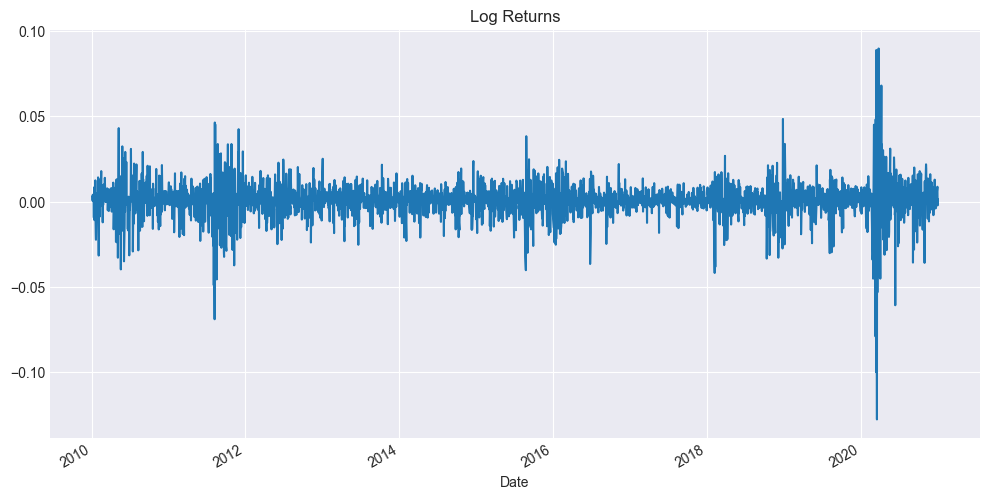

In [5]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [6]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

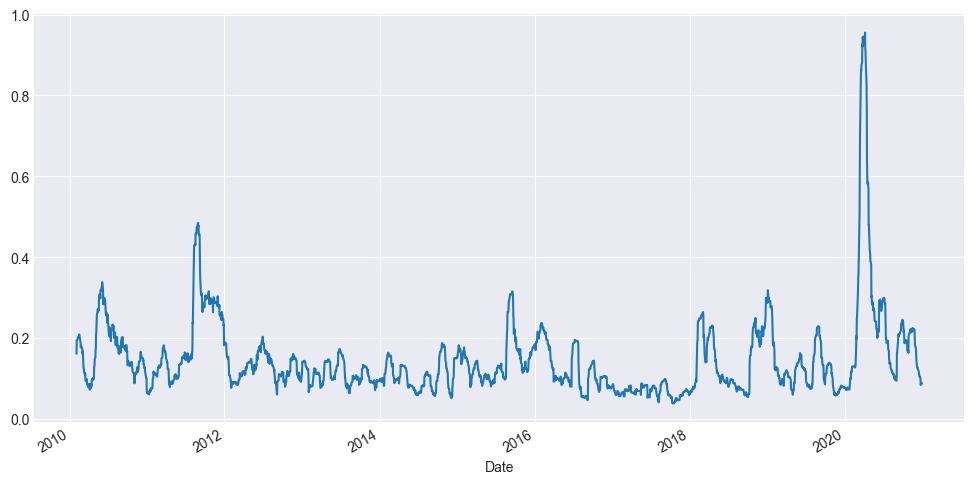

In [7]:
spx["rv_close"] = rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()

## 2.2 Range-Based Proxies (OHLC)

Instead of relying only on closing prices, we can extract more information from each trading day by incorporating the **Open, High, Low, and Close (OHLC)** prices.  
Over the years, several range-based estimators have been proposed, each addressing specific shortcomings of the close-to-close method and earlier estimators.  
These approaches typically reduce variance in the volatility estimate and account for intraday dynamics, but each comes with its own assumptions and limitations.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

In [8]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

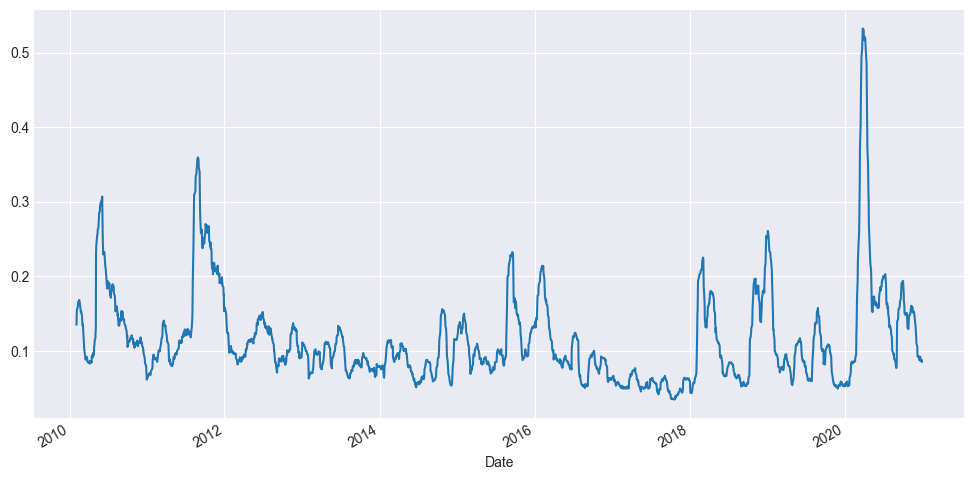

In [9]:
spx["rv_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

In [10]:
def rv_garman_klass(open_, high, low, close, h=21, ann=252):
    # Daily GK variance (no drift)
    rs = 0.5 * (np.log(high/low).pow(2)) - (2*np.log(2) - 1) * (np.log(close/open_).pow(2))
    var = rs.rolling(h).sum() * (ann / h)
    return np.sqrt(var)

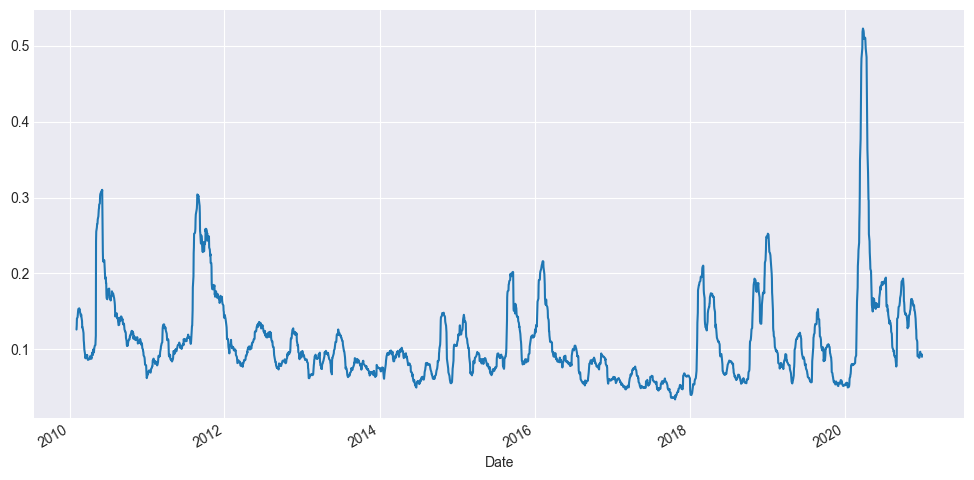

In [11]:
spx["rv_gk"] = rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The **Rogers–Satchell (1991) estimator** was introduced to overcome one of the limitations of the Parkinson and Garman–Klass estimators: their assumption of zero drift.  
The Rogers–Satchell measure is **drift-robust**, making it better suited for assets that experience trending behavior.  
It uses all four OHLC prices, but in a different functional form that explicitly accommodates nonzero expected returns.  

While it handles drift effectively, it remains sensitive to microstructure noise and extreme jumps at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

In [12]:
def rv_rogers_satchell(open_, high, low, close, h=21, ann=252):
    term1 = np.log(high/close) * np.log(high/open_)
    term2 = np.log(low/close) * np.log(low/open_)
    rs = (term1 + term2)
    var = rs.rolling(h).sum() * (ann/h)
    return np.sqrt(var)

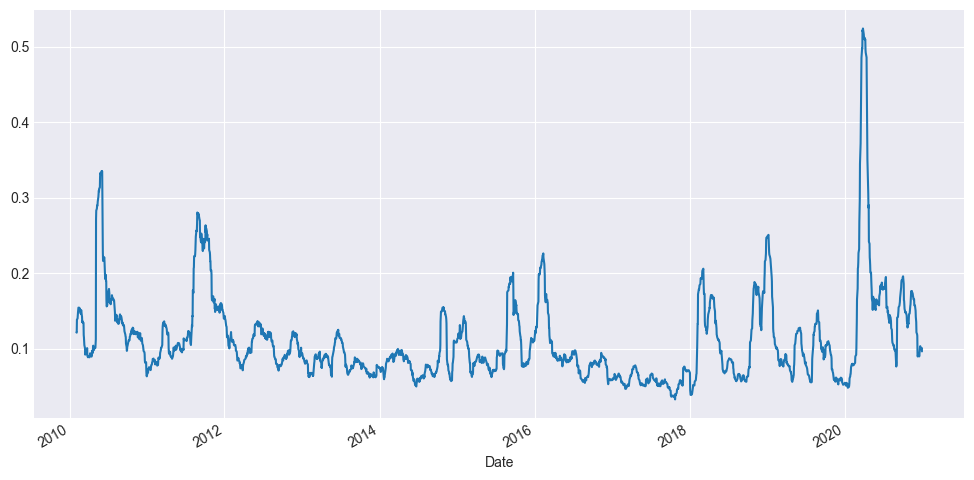

In [13]:
spx["rv_rs"] = rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

In [14]:
def rv_yang_zhang(open_, high, low, close, h=21, ann=252, k=0.34):
    # Overnight return variance
    oc = np.log(open_/close.shift(1))
    sigma_o = oc.pow(2)

    # Open-to-close variance
    co = np.log(close/open_)
    sigma_c = co.pow(2)

    # Rogers–Satchell component
    rs = (
        np.log(high/close) * np.log(high/open_) +
        np.log(low/close) * np.log(low/open_)
    )

    # Daily YZ variance
    yz = sigma_o + k*sigma_c + (1-k)*rs

    var = yz.rolling(h, min_periods=h).sum() * (ann/h)
    return np.sqrt(var)

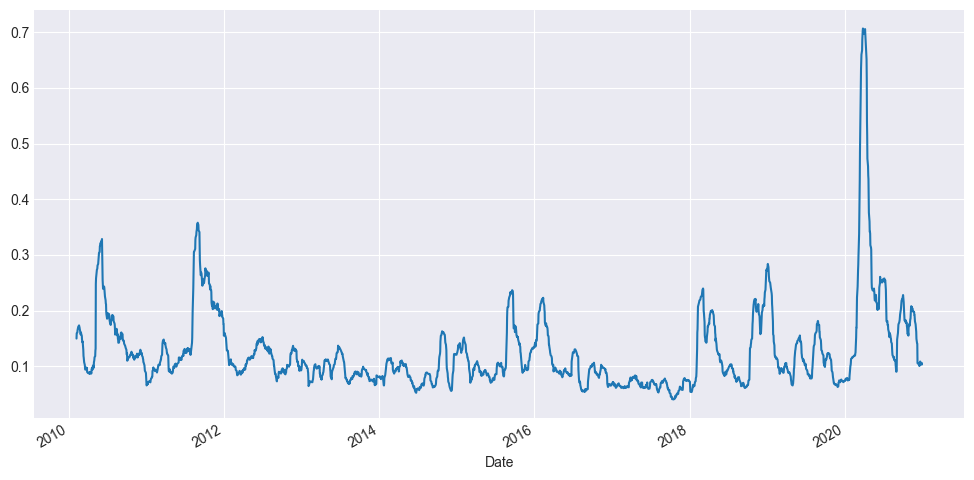

In [15]:
spx["rv_yz"] = rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

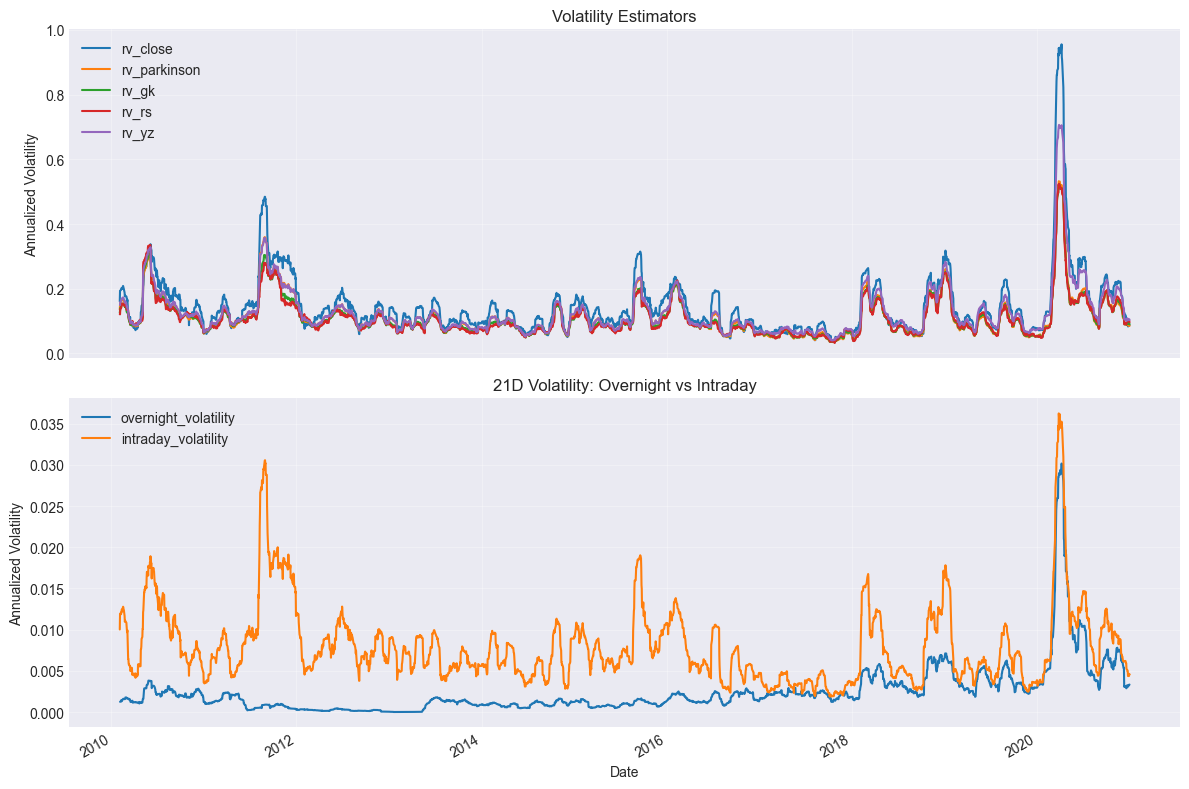

In [16]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [17]:
es_5min = pd.read_csv("data/intermediate/es-5m.csv", 
                 sep=";", 
                 header=None,
                 names=["date","time","open","high","low","close","volume"])

es_5min["datetime"] = pd.to_datetime(es_5min["date"] + " " + es_5min["time"], 
                                     format="%d/%m/%Y %H:%M:%S")

es_5min = es_5min.drop(columns=["date","time"]).set_index("datetime").sort_index()

es_5min = es_5min.loc[start:end]
es_5min

,open,high,low,close,volume
datetime,,,,,
2010-01-03 17:00:00,1113.75,1115.25,1113.25,1114.25,4700
2010-01-03 17:05:00,1114.25,1115.50,1114.25,1114.75,1804
2010-01-03 17:10:00,1114.50,1115.25,1114.50,1115.00,785
2010-01-03 17:15:00,1115.25,1116.00,1114.75,1115.75,1143
2010-01-03 17:20:00,1115.75,1116.25,1115.50,1116.00,643
...,...,...,...,...,...
2020-12-31 15:35:00,3746.75,3747.25,3746.00,3746.75,902
2020-12-31 15:40:00,3746.75,3747.25,3746.50,3747.00,582
2020-12-31 15:45:00,3747.00,3747.50,3745.75,3746.75,879


In [18]:
es_5min.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [19]:
es_5min[es_5min.index.duplicated(keep=False)]

,open,high,low,close,volume
datetime,,,,,


In [20]:
es_5min = es_5min[~es_5min.index.duplicated(keep="last")]

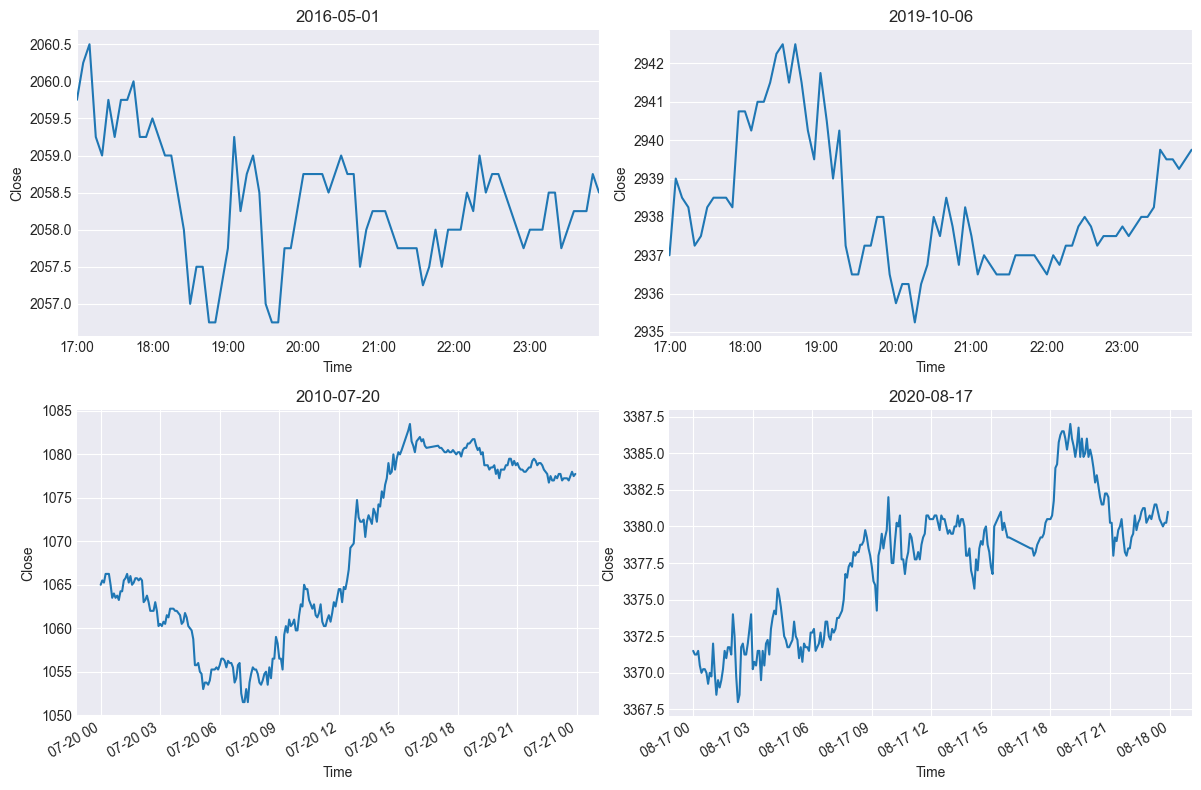

In [21]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [22]:
def daily_realized_variance(close, rth_start: str = "09:30", rth_end: str = "16:00"):
    """
    Compute daily realized variance from intraday data:
        RV_t = sum_i r_{t,i}^2, where r_{t,i} = log(P_{t,i}/P_{t,i-1})
    """
    # intraday log returns
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()
    r = np.log(rth).diff()

    # sum of squared intraday returns by day
    rv_daily = r.pow(2).groupby(rth.index.date).sum()
    rv_daily.index = pd.to_datetime(rv_daily.index)
    rv_daily.name = "var_daily"

    return rv_daily

In [23]:
daily_rv = daily_realized_variance(es_5min["close"])
es_rv_21 = np.sqrt(daily_rv.rolling(21).mean() * 252)

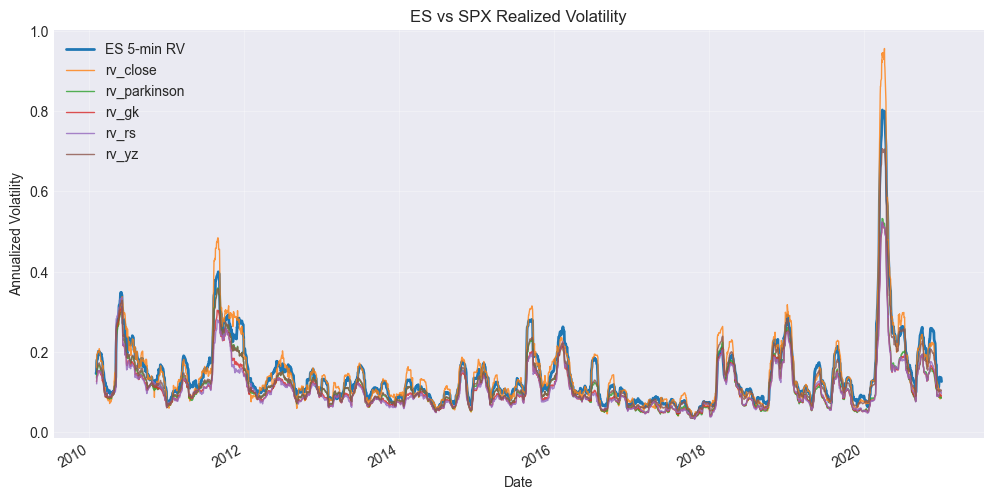

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

# **3. Stylized facts of daily volatility**

Here we will be investgating stylized facts of daily volatility that can be used for modelling perspective. The idea is to highlight the key charcetristics of daily varaicne that can be leveraged to forecast the future volaitltiy. From a modellign perspective it is betetr to work diertcly with varaicne instea dof std (isnce variance is additive) as well as dealing with the daily one isnetad of teh monthyl rollign one (which does not align with the stylized fatcs which come from daily frequency).

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect

## 3.1 Volatility clustering

It is the msot important phenomena as volatility is not constant, it evolves in low and high volatility regimes respecitvely. The idea is that high (resp. low) level of voalitlities tend to be follwoed by high (resp. low) level of volaitlity respectievly.

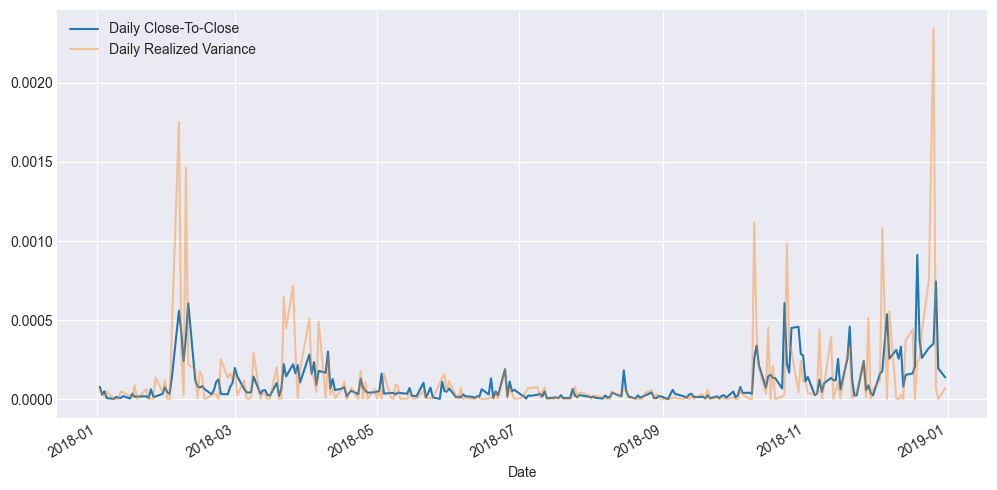

In [25]:
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squarred retursn and realized varaicne show strong persiteenc eover many lags. Means today’s volatility has predictive power even months ahead. Thi smotivates the use of HAR-RV models that parsimuniusly include many lags until monthyl lags.

In [26]:
def plot_acf_pacf(series, lags=40, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF {title}")

    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method="ywm")  # Yule-Walker-M estimator
    axes[1].set_title(f"PACF {title}")

    plt.tight_layout()
    plt.show()

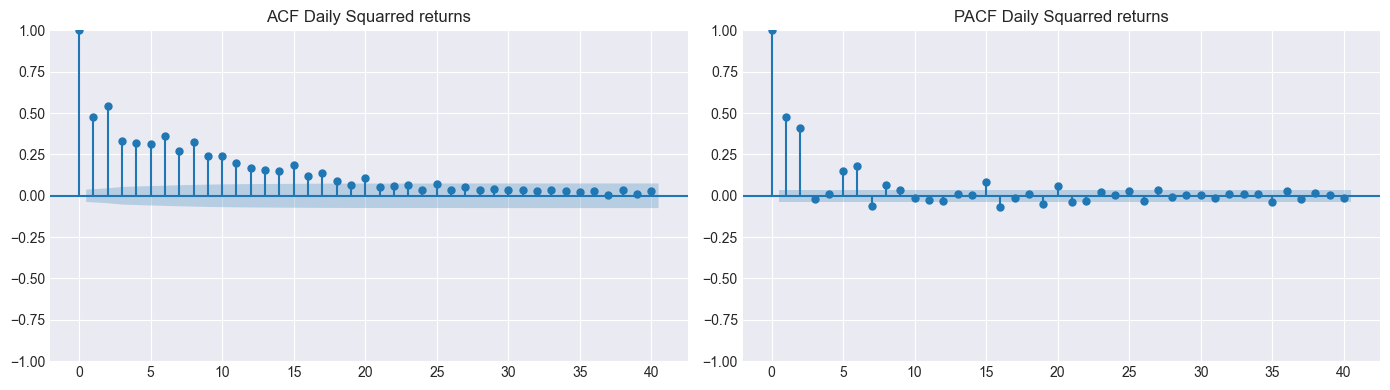

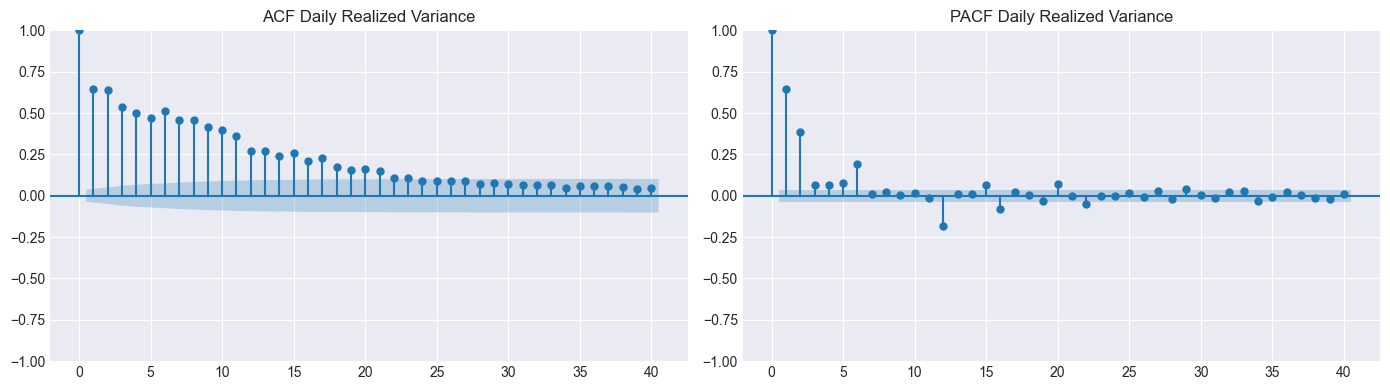

In [27]:
plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

For short horizons, the realized varaicne is more persitent than the close-to-close appromxiated by squarred returns with lags which ate meaningful until 1 months thus we could use autoregressive terms until the 21th to forecast teh next day volatility.

## 3.3 Mean-reverting behaviour

In [28]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 2835
Model:                     AutoReg(1)   Log Likelihood               19576.101
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 05 Nov 2025   AIC                         -39146.202
Time:                        09:21:00   BIC                         -39128.354
Sample:                             1   HQIC                        -39139.764
                                 2835                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.869e-05   4.81e-06      8.045      0.000    2.93e-05    4.81e-05
y.L1           0.6461      0.014     45.068      0.000       0.618       0.674
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to **log-normal**.  
In other words, while raw volatility (RV, IV) has a heavy-tailed distribution,  
its logarithm is much closer to Normal.

**Modeling benefits:**
- **Positivity:** By modeling log-volatility and exponentiating back, forecasts are guaranteed ≥ 0.  
- **Better fit:** Log-volatility is closer to Gaussian → forecast errors are more symmetric and homoscedastic.  
- **Statistical validity:** Standard linear models (ARMA, HAR-RV, regressions) work more reliably on log-volatility.  

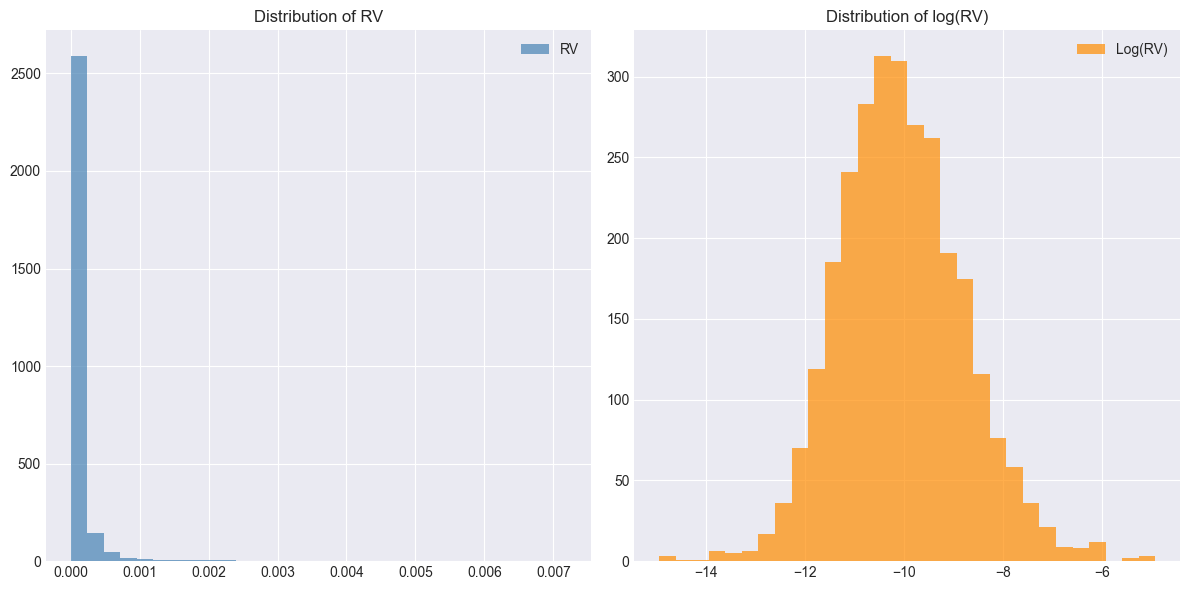

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

daily_rv.hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of RV")
axes[0].legend()

np.log(daily_rv).hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of log(RV)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Asymmetry / Leverage Effect

Another key stylized fact is the **asymmetric relation between returns and volatility**:  
- Negative returns (price drops) tend to increase future volatility more than positive returns of the same magnitude.  
- This is often called the **leverage effect**, since a fall in equity prices increases financial leverage, making the firm riskier.  
- In practice, this creates an asymmetric volatility–return correlation:
  - Correlation between returns and future volatility < 0.

**Modeling implications:**
- Symmetric models (e.g., standard GARCH) cannot capture this.  
- Asymmetric extensions such as EGARCH, GJR-GARCH, or stochastic volatility with leverage are used to account for it.  

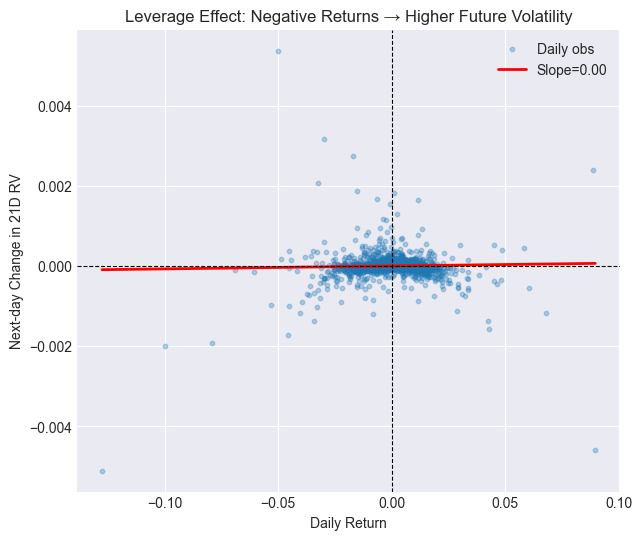

In [30]:
# --- Next-day change in volatility ---
dvol = daily_rv.shift(-1) - daily_rv   # Δvol at t+1

# Align
df = pd.concat([spx["returns"], dvol], axis=1).dropna()
df.columns = ["ret", "dvol"]

# --- Scatterplot ---
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df["ret"], df["dvol"], alpha=0.3, s=10, label="Daily obs")

# Fit regression line
m, b = np.polyfit(df["ret"], df["dvol"], 1)
x_vals = np.linspace(df["ret"].min(), df["ret"].max(), 100)
ax.plot(x_vals, m*x_vals + b, color="red", lw=2, label=f"Slope={m:.2f}")

# Axes + titles
ax.axhline(0, color="black", ls="--", lw=0.8)
ax.axvline(0, color="black", ls="--", lw=0.8)
ax.set_xlabel("Daily Return")
ax.set_ylabel("Next-day Change in 21D RV")
ax.set_title("Leverage Effect: Negative Returns → Higher Future Volatility")
ax.legend()

plt.show()

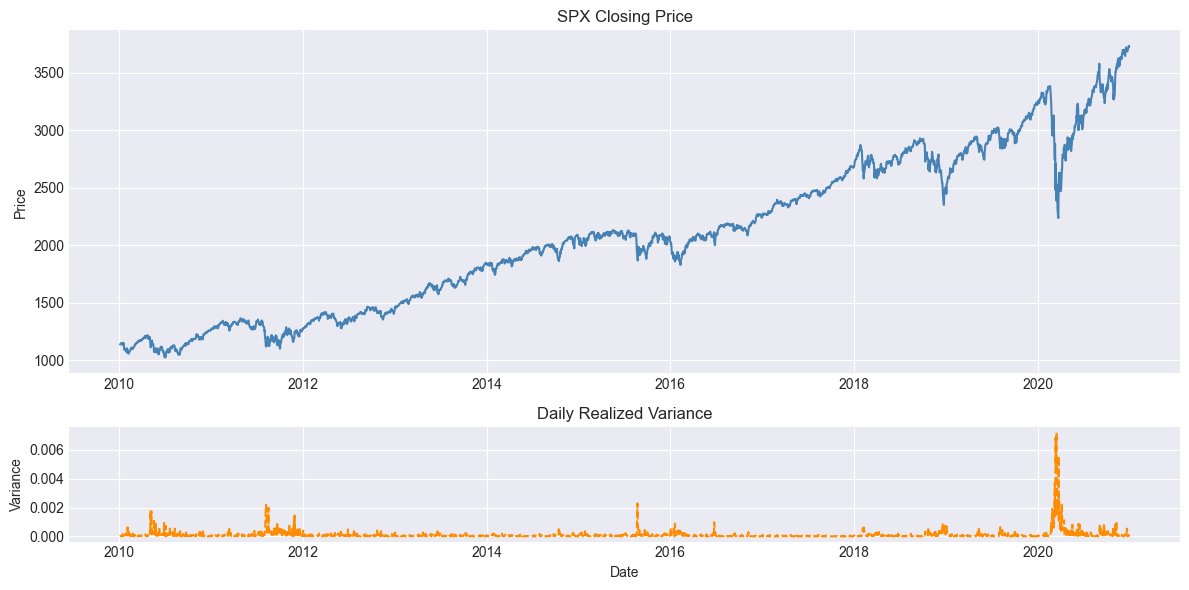

In [31]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # top 3x bigger than bottom

# Top: SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# Bottom: realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can see that durign stress regimes voalitltiy tend to spike.

# **4. Problem Formulation**

We frame the task as a supervised learning problem: forecasting the 21-day forward realized volatility of the S&P 500.

Formally, the objective is to predict forward realized volatility using only information available at time $t$.  

$$
y_t = f(X_t; \beta) + \varepsilon_t, \quad \text{with } \mathbb{E}[y_t | X_t] = f(X_t; \beta)
$$

where:
- $y_t$ = target variable (forward 21-day realized volatility),
- $X_t$ = vector of predictors at time $t$.
- $f(.;\beta)$ = parametric or non-parametric form of the regressors


## 4.1 Target Variable: 21-Day Realized Variance

For forecasting purposes, it is convenient to define the target in terms of **daily realized volatility** averaged over the forward horizon.  
This follows the econometric convention (Christoffersen, Corsi, etc.), where multi–day realized volatility is expressed as the mean of daily RVs rather than as total variance.

Since realized variance and volatility are highly skewed and approximately log-normal, we work in the **logarithmic scale**:

$$
y_t = \log\!\big(RV_{t+1:t+21}\big)
$$

where the forward 21-day realized variance aligned at time $t$ is defined as:

$$
RV_{t+1:t+21} 
= \frac{RV_{t+1} + RV_{t+2} + \cdots + RV_{t+21}}{21}
$$

with $RV_{t+i}$ denoting the one-day realized volatility computed from intraday (5-min) returns.

- The **log transform** reduces skewness, stabilizes variance, and makes the distribution closer to Gaussian.  
- It also guarantees positivity when transformed back:

$$
\hat{RV}_{t+1:t+21} = \exp(\hat{y}_t).
$$

In [202]:
def create_forward_target(daily_variance: pd.Series, horizon: int = 21) -> pd.Series:
    """
    daily_variance: per-day realized variance (NOT sqrt, NOT annualized).
                    index = trading days.
    horizon: forecast horizon in trading days (e.g. 21 ~ 1 month).

    Returns:
        y_t = log( average future variance from t+1 to t+horizon )
    """
    # trailing mean, then realign to t as forward mean
    fwd_avg_var = (
        daily_variance
        .rolling(horizon).mean()       # at t+h: mean of [t+1 .. t+h]
        .shift(-horizon)               # move it back so it's aligned at t
    )

    y = np.log(fwd_avg_var)
    y.name = f"log_fwd_var_{horizon}d"
    return y

H = 21
y = create_forward_target(daily_rv, horizon=14)

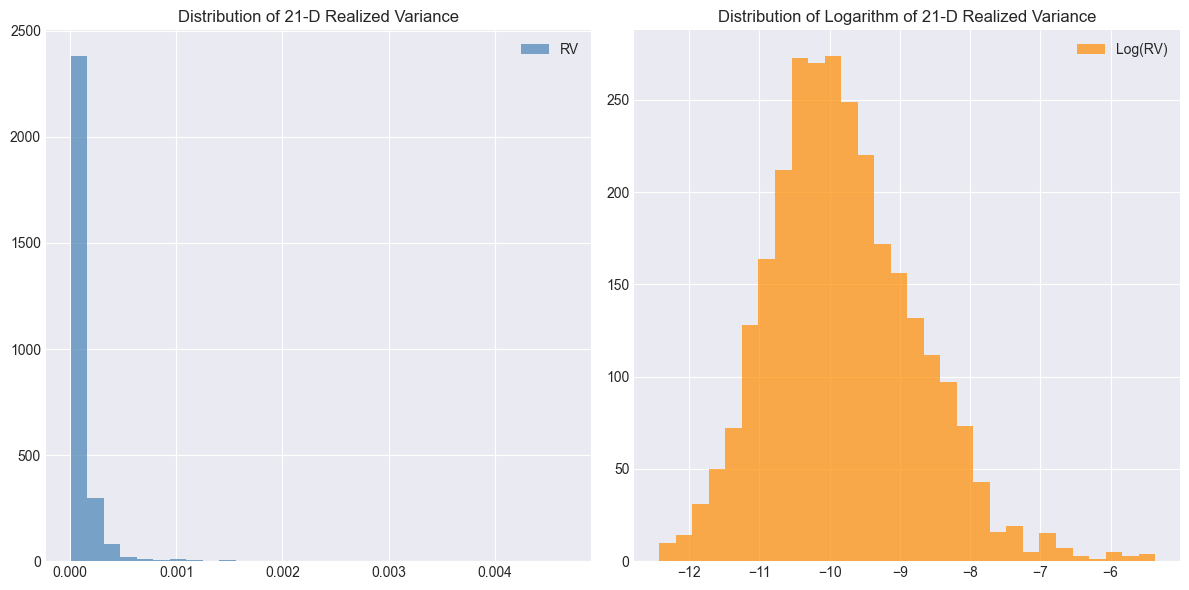

In [112]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

np.exp(y).hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of 21-D Realized Variance")
axes[0].legend()

y.hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of Logarithm of 21-D Realized Variance")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4.2 Predictor Families

We use features observable at time (t), grouped into families where each fmailly covers one parituclar aspect of the foward RV.

### 4.2.1 Lagged Volatility Measures: HAR-RV Lags (1D, 5D, 22D)

As seen in the ACF plots, realized variance exhibits strong persistence, remaining significant up to at least 21 lags. This motivates the use of **lagged realized variance/volatility** as predictors.

A common specification is the **HAR-RV (Heterogeneous Autoregressive) structure**, which captures short, medium, and long-term memory effects by including daily, weekly, and monthly averages of past realized variance:

$$
X_{t}^{HAR} = RV_{D,t} + RV_{W,t} + RV_{M,t}
$$

where:
- $RV_{D,t} = RV_{t}$ (daily lag, short-term persistence)  
- $RV_{W,t} = \tfrac{1}{5}\sum_{i=0}^{4} RV_{t-i}$ (weekly average, medium-term)  
- $RV_{M,t} = \tfrac{1}{21}\sum_{i=0}^{20} RV_{t-i}$ (monthly average, long-term)  

This formulation smooths noisy daily lags and reflects the heterogeneous behavior of different market participants (daily traders, weekly rebalancers, monthly institutions).

In [113]:
def create_har_lags(real_variance):
    X_har = pd.DataFrame({
        "RV_D": real_variance,                   # yesterday’s daily RV
        "RV_W": real_variance.rolling(5).mean(), # weekly avg of daily RVs
        "RV_M": real_variance.rolling(21).mean() # monthly avg of daily RVs
    })
    return X_har

X_har = create_har_lags(daily_rv)

In [114]:
summary_stats = ['count','mean','std','min','max','skew','kurtosis']

X_har = create_har_lags(daily_rv)
X_har.agg(summary_stats)

,RV_D,RV_W,RV_M
count,2.835000e+03,2831.000000,2815.000000
mean,1.092941e-04,0.000109,0.000110
std,3.170964e-04,0.000263,0.000219
min,3.257165e-07,0.000004,0.000006
max,7.191973e-03,0.004678,0.002556
skew,1.255384e+01,10.254128,7.915824
kurtosis,2.195748e+02,135.858842,74.452912


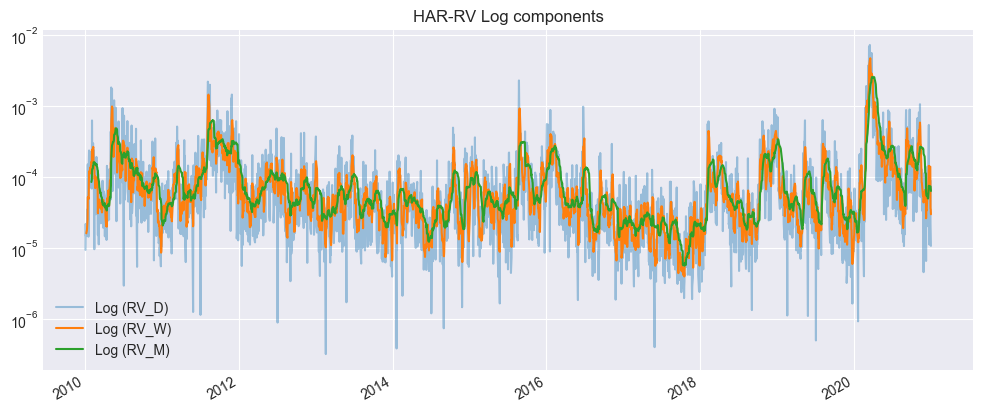

In [115]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_yscale("log")
X_har["RV_D"].plot(ax=ax, alpha=0.4, label="Log (RV_D)")
X_har["RV_W"].plot(ax=ax, alpha=1, label="Log (RV_W)")
X_har["RV_M"].plot(ax=ax, alpha=1, label="Log (RV_M)")
plt.legend(); plt.title("HAR-RV Log components")
plt.show()

In [116]:
def plot_features_vs_target(X, y, log_features=None, figsize=(12, 6), cmap="viridis", nrows=None, ncols=None):
    log_features = log_features or []

    if not ncols:
        n_cols = len(X.columns)
        ncols = 2

    if not nrows:
        nrows = (n_cols + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, X.columns):
        x = X[col].to_numpy()

        if col in log_features:
            x = np.log(x + 1e-8)  # small offset to avoid log(0)
            x_label = f"log({col})"
        else:
            x_label = col

        hb = ax.hexbin(x, y, gridsize=40, mincnt=1, cmap=cmap)
        ax.set_title(f"{x_label} vs log(y)")
        ax.set_xlabel(x_label)
        ax.set_ylabel("log(y)")
        fig.colorbar(hb, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()

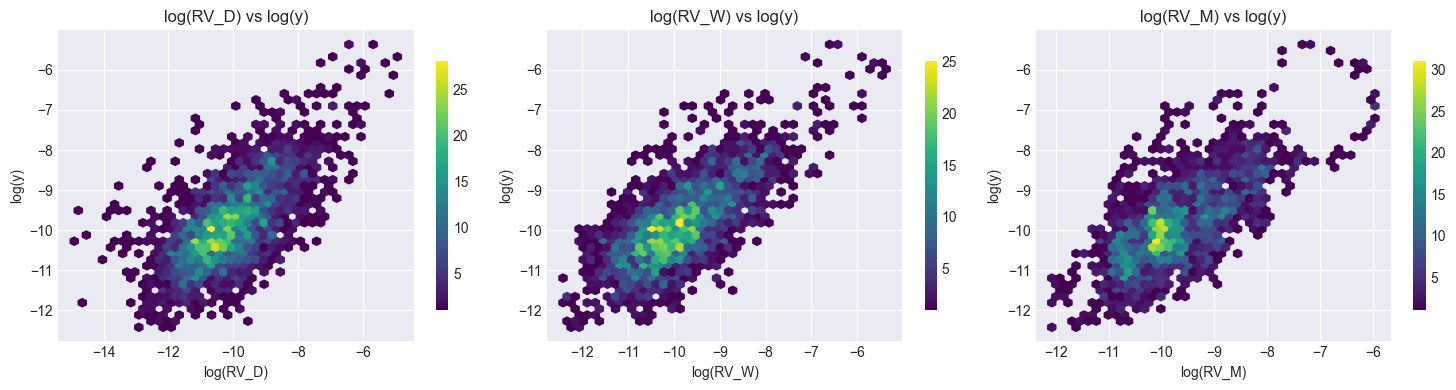

In [117]:
plot_features_vs_target(X_har, y, log_features=X_har.columns.tolist(), figsize=(15, 4), nrows=1, ncols=3)

#### **Transformation Decisions**
- Apply `log` transform to: `RV_D`, `RV_W`, `RV_M`.

### 4.2.2 Implied Volatility Signals  

While realized volatility lags capture **persistence**, implied volatility (IV) embeds the market’s **forward-looking expectations** of future volatility and risk premia.  
Here we focus on features derived from the option surface of the underlying we trade:

- **ATM IV (1M maturity)**  
  Near-the-money implied volatility for ~1-month options, closely linked to the traded option premium and less contaminated by skew than indices such as VIX.  

- **IV Skew / Slope**  
  Difference between OTM put IV and ATM IV (or put–call wing differences).  
  Acts as a proxy for the **downside risk premium** and crash protection demand: steeper skew often corresponds to elevated tail-risk pricing.  

- **IV Term Structure**  
  Slope between short- and long-dated IVs (e.g. 10D vs 1M, 1M vs 3M).  
  An **inverted term structure** (front IV > back IV) typically signals near-term stress, whereas an upward-sloping structure is more consistent with benign or mean-reverting volatility regimes.  

These IV-based predictors complement RV lags by providing a **market-implied view of future volatility**, which is central for constructing IV–RV mispricing signals.

In [124]:
spx_options = pd.read_parquet("data/intermediate/full_spx_options_2010_2020.parquet")

spx_options["T"] = spx_options["dte"] / 252 # Time to expity in years
spx_options["k"] = np.log(
    spx_options["strike"] / spx_options["underlying_last"] # Log-forward moneyness
 )

In [1112]:
import numpy as np
import pandas as pd
from scipy.stats import norm

def bs_delta_call(S, K, T, sigma, r=0.0, q=0.0):
    if sigma <= 0 or T <= 0:
        return 0.0
    d1 = (np.log(S / K) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    return np.exp(-q * T) * norm.cdf(d1)

def bs_delta_put(S, K, T, sigma, r=0.0, q=0.0):
    # put delta = call delta - e^{-qT}
    return bs_delta_call(S, K, T, sigma, r, q) - np.exp(-q * T)

def solve_strike_for_delta(target_delta, S, T, sigma, option_type, r=0.0, q=0.0, 
                            K_min_factor=0.2, K_max_factor=3.0, tol=1e-6, max_iter=100):
    """
    Solve for strike K such that the (spot) delta equals target_delta.
    Uses bisection with a fixed sigma (e.g. ATM vol) as approximation.
    """
    K_low = K_min_factor * S
    K_high = K_max_factor * S

    if option_type == "call":
        delta_low = bs_delta_call(S, K_low, T, sigma, r, q)
        delta_high = bs_delta_call(S, K_high, T, sigma, r, q)
    else:  # put
        delta_low = bs_delta_put(S, K_low, T, sigma, r, q)
        delta_high = bs_delta_put(S, K_high, T, sigma, r, q)

    # Ensure target_delta is within bracket; if not, just clip
    if not (min(delta_low, delta_high) <= target_delta <= max(delta_low, delta_high)):
        # simple fallback: return ATM
        return S

    for _ in range(max_iter):
        K_mid = 0.5 * (K_low + K_high)
        if option_type == "call":
            delta_mid = bs_delta_call(S, K_mid, T, sigma, r, q)
        else:
            delta_mid = bs_delta_put(S, K_mid, T, sigma, r, q)

        if abs(delta_mid - target_delta) < tol:
            return K_mid

        # Bisection step
        if (delta_low - target_delta) * (delta_mid - target_delta) <= 0:
            K_high = K_mid
            delta_high = delta_mid
        else:
            K_low = K_mid
            delta_low = delta_mid

    return K_mid  # last iterate if not converged


def create_iv_surface_predictors(options, iv_surface_model, params=None, r=0.0, q=0.0):
    iv_features = []
    T_30 = 30 / 252
    T_60 = 60 / 252

    for date, chain in options.groupby("date"):
        # --- Underlying spot (ATM anchor) ---
        S = float(chain["underlying_last"].iloc[0])

        # --- Fit or restore the surface ---
        if params is None or date not in params:
            iv_surface_model.fit(chain)
        else:
            iv_surface_model.set_params({**params[date], "spot": S})

        # --- ATM IVs ---
        atm_iv_30d = iv_surface_model.implied_vol(S, T_30)
        atm_iv_60d = iv_surface_model.implied_vol(S, T_60)

        # --- 25Δ strikes (approx using ATM vol for the delta inversion) ---
        # target deltas: put = -0.25, call = +0.25
        K_put_25d = solve_strike_for_delta(
            target_delta=-0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="put",
            r=r,
            q=q
        )
        K_call_25d = solve_strike_for_delta(
            target_delta=0.25,
            S=S,
            T=T_30,
            sigma=atm_iv_30d,
            option_type="call",
            r=r,
            q=q
        )

        # --- 25Δ skew (downside - upside) ---
        iv_put_25d = iv_surface_model.implied_vol(K_put_25d, T_30)
        iv_call_25d = iv_surface_model.implied_vol(K_call_25d, T_30)
        iv_skew = iv_put_25d - iv_call_25d

        # --- Term structure slope (30D → 60D) ---
        iv_ts = atm_iv_60d - atm_iv_30d

        iv_features.append({
            "date": date,
            "atm_iv_30d": atm_iv_30d,
            "iv_skew": iv_skew,
            "iv_ts": iv_ts,
        })

    iv_features = pd.DataFrame(iv_features).set_index("date").sort_index()
    return iv_features

In [1113]:
ssvi = SSVI()
df_g = pd.read_parquet("ssvi_globals_2010_2020.parquet")
df_k = pd.read_parquet("ssvi_knots_2010_2020.parquet")

params_ssvi = ssvi.build_params_dict(df_g, df_k)
X_iv_surface = create_iv_surface_predictors(spx_options, ssvi, params=params_ssvi)

#### Correct data error from iv puts

In [1117]:
X_iv_surface.loc["2019-05-02":"2019-05-08", :] = np.nan
X_iv_surface.loc["2019-05-17", :] = np.nan
X_iv_surface = X_iv_surface.interpolate(method="linear")

X_iv_surface.agg(summary_stats)

,atm_iv_30d,iv_skew,iv_ts
count,2835.000000,2835.000000,2835.000000
mean,0.149376,0.067752,0.007421
std,0.066764,0.029388,0.011248
min,0.062058,0.024176,-0.087146
max,0.776023,0.429290,0.080241
skew,2.618590,3.522620,-1.728868
kurtosis,12.771528,25.062136,12.562780


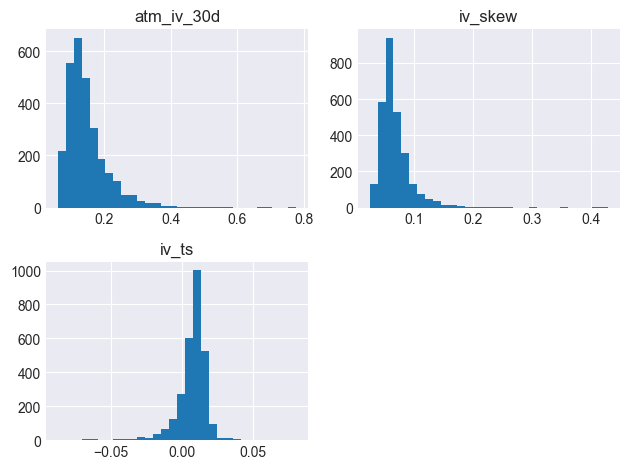

In [1118]:
X_iv_surface.hist(bins=30)
plt.tight_layout()
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `VIX`, `VVIX`, `iv_atm_30`, `iv_atm_60`.
- Apply Yeo-Johnson transform to: `iv_ts`

*Remarque*:
Could apply log transform to iv_skew but since it has moderate skewness < 1
we decide to keep the original predictor

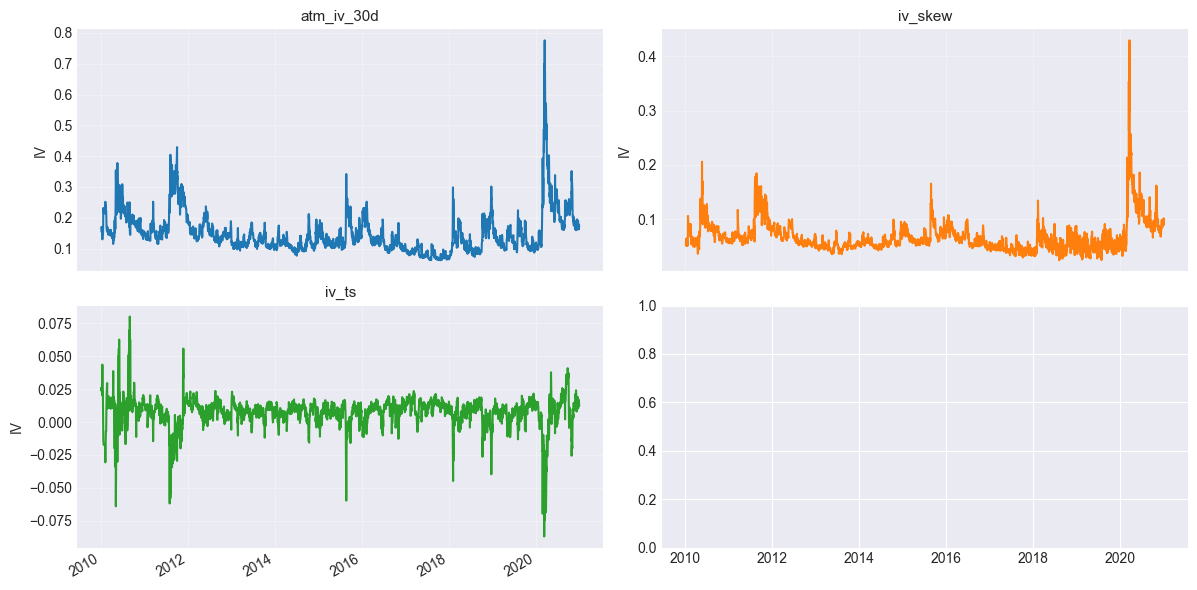

In [1119]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # blue, orange, green, red

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

for ax, col, c in zip(axes.flat, X_iv_surface.columns, colors):
    X_iv_surface[col].plot(ax=ax, lw=1.5, color=c)
    ax.set_title(col, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylabel("IV")
    
plt.tight_layout()
plt.show()

In [1120]:
X_iv_surface = X_iv_surface.reindex(y.index).ffill()

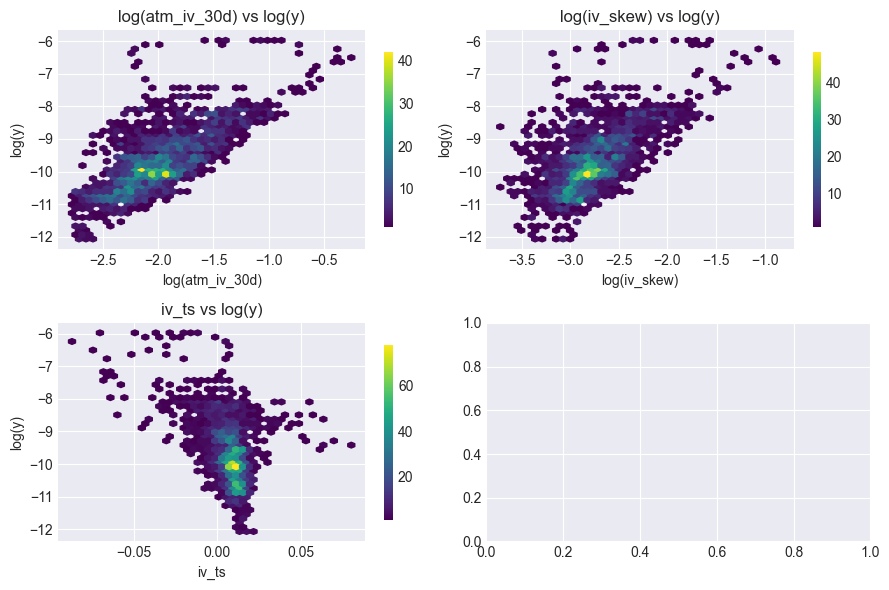

In [1121]:
plot_features_vs_target(X_iv_surface, y, log_features=["atm_iv_30d", "iv_skew"], figsize=(9, 6))

### 4.2.3 Return-related predictors: absolute returns, past squared returns, Realized skewness / kurtosis

In [132]:
def create_return_predictors(returns: pd.Series, h: int = 21) -> pd.DataFrame:
    ret_features = pd.DataFrame(index=returns.index)

    # Absolute and squared returns
    ret_features["abs_r"] = returns.abs()
    ret_features["r2"] = returns.pow(2)

    # Realized skewness & kurtosis over horizon h
    rolling_r = returns.rolling(h)
    ret_features["skew"] = rolling_r.apply(lambda x: ((x / x.std())**3).mean(), raw=False)
    ret_features["kurt"] = rolling_r.apply(lambda x: ((x / x.std())**4).mean(), raw=False)

    return ret_features

In [133]:
X_returns = create_return_predictors(spx["returns"], h=H)
X_returns = X_returns.reindex(y.index).ffill()
X_returns.agg(summary_stats)

,abs_r,r2,skew,kurt
count,2834.000000,2834.000000,2813.000000,2813.000000
mean,0.007019,0.000121,0.191340,3.408498
std,0.008480,0.000516,0.992732,1.400154
min,0.000000,0.000000,-3.208464,1.457295
max,0.127652,0.016295,3.399189,13.121545
skew,4.158376,17.689898,0.199356,1.840437
kurtosis,33.142519,437.478032,-0.182521,5.160144


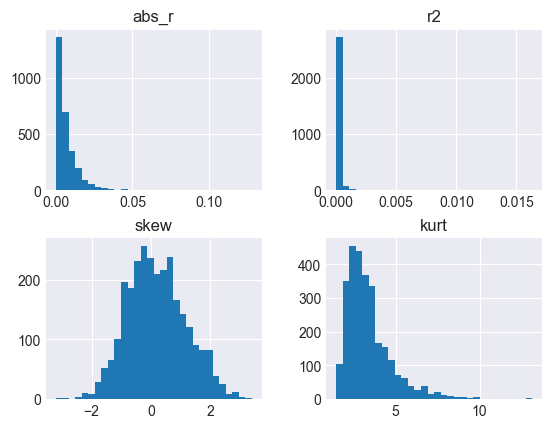

In [134]:
X_returns.hist(bins=30)
plt.show()

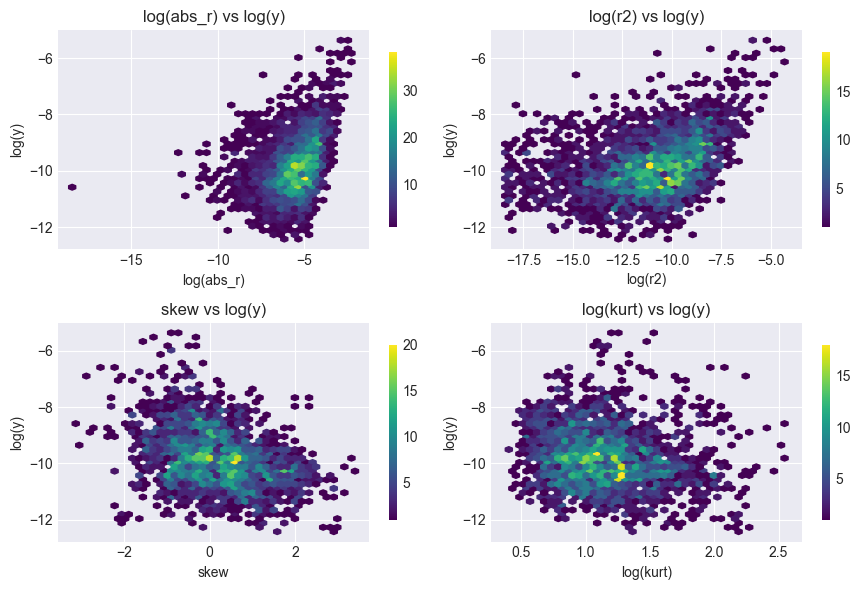

In [135]:
plot_features_vs_target(X_returns, y, log_features=["abs_r", "r2", "kurt"], figsize=(9, 6))

Here we cna observe a sligth non-linearity that cna be leevraged through non-linear models.

### 4.2.4 Macro & Market Predictors  

This category combines **macro fundamentals** (rates, credit spreads) with **market-based measures** (volume, liquidity, realized correlations).  
Though generally less predictive than RV lags or IV signals, they can add value in stress regimes and are well suited to **machine learning models**, which can exploit non-linearities across a broader set of features.

#### Macro Fundamentals  

Here we include **slow-moving economic and financial variables** that capture the broader macro environment.  
These are unlikely to explain day-to-day fluctuations in volatility but may contain information about **regime shifts** (e.g. monetary tightening, credit stress) that affect forward realized volatility:  

- **Interest rate levels & term spreads**: Treasury yields (e.g. 3M, 2Y, 10Y), slope of the yield curve.  
- **Credit spreads**: Investment-grade and high-yield spreads, proxies for systemic financial stress.  

These predictors move more slowly than market-based signals but help identify **macro-driven volatility regimes** (e.g. high-rate environments, credit crises).

In [ ]:
# --- Load FRED API key from environment ---
load_dotenv()
FRED = None
try:
    from fredapi import Fred
    api_key = os.getenv("FRED_API_KEY")  # loaded from .env or system env
    if api_key:
        FRED = Fred(api_key=api_key)
        print("FRED API loaded.")
    else:
        print("No FRED API key found in environment. Macro features will be empty.")
except ImportError:
    print("fredapi not installed. Install with `pip install fredapi`.")

# --- Helper to fetch a single FRED series ---
def _fred_series(series_id, start=None, end=None):
    if FRED is None:
        return pd.Series(dtype=float, name=series_id)
    s = FRED.get_series(series_id, observation_start=start, observation_end=end)
    s = pd.Series(s, name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

# --- Main macro feature builder ---
def create_macro_features(start="2005-01-01", end=None):
    # --- Treasury yields ---
    DGS10  = _fred_series("DGS10",  start, end).rename("DGS10")   # 10Y yield (%)
    DGS2   = _fred_series("DGS2",   start, end).rename("DGS2")    # 2Y yield (%)
    DGS3MO = _fred_series("DGS3MO", start, end).rename("DGS3MO")  # 3M yield (%)
    term_spread = (DGS10 - DGS3MO).rename("term_spread_10y_3m")

    # --- Credit spreads ---
    HY_OAS = _fred_series("BAMLH0A0HYM2", start, end).rename("HY_OAS")   # High Yield OAS (%)
    IG_OAS = _fred_series("BAMLC0A0CM",   start, end).rename("IG_OAS")   # IG OAS (%)

    df = pd.concat([DGS10, DGS2, DGS3MO, term_spread, HY_OAS, IG_OAS], axis=1).sort_index()

    # Business-day frequency; forward-fill for sparse macro data
    df = df.asfreq("B")
    df = df.ffill()

    return df

FRED API loaded.


In [58]:
X_macro = create_macro_features(start=start, end=end)

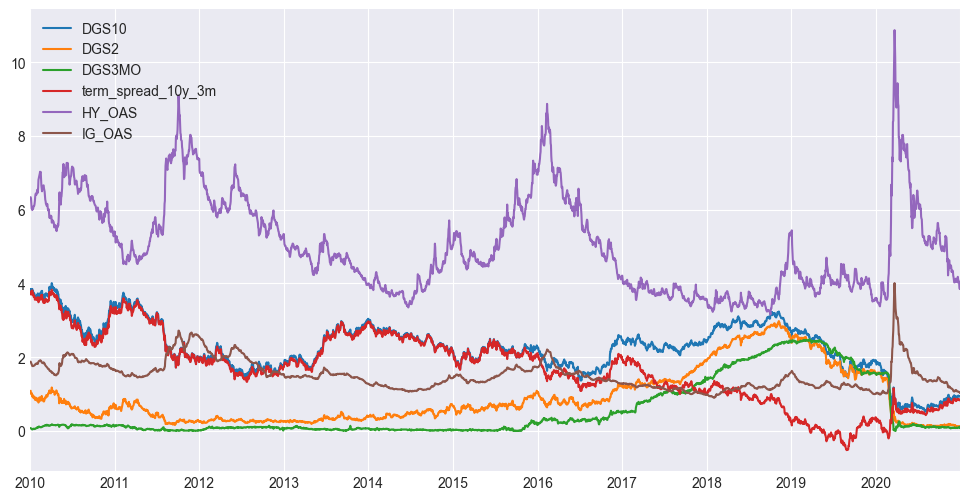

In [59]:
X_macro.plot(figsize=(12, 6))
plt.show()

In [60]:
X_macro.agg(summary_stats)

,DGS10,DGS2,DGS3MO,term_spread_10y_3m,HY_OAS,IG_OAS
count,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000,2869.000000
mean,2.266386,0.909913,0.557640,1.708745,5.045852,1.507881
std,0.691805,0.747697,0.777146,0.958607,1.277921,0.387046
min,0.520000,0.110000,0.000000,-0.520000,3.160000,0.900000
max,4.010000,2.980000,2.490000,3.830000,10.870000,4.010000
skew,-0.240419,1.157739,1.337855,-0.083195,0.777234,1.348940
kurtosis,0.193617,0.237751,0.238467,-0.607180,0.097309,2.859696


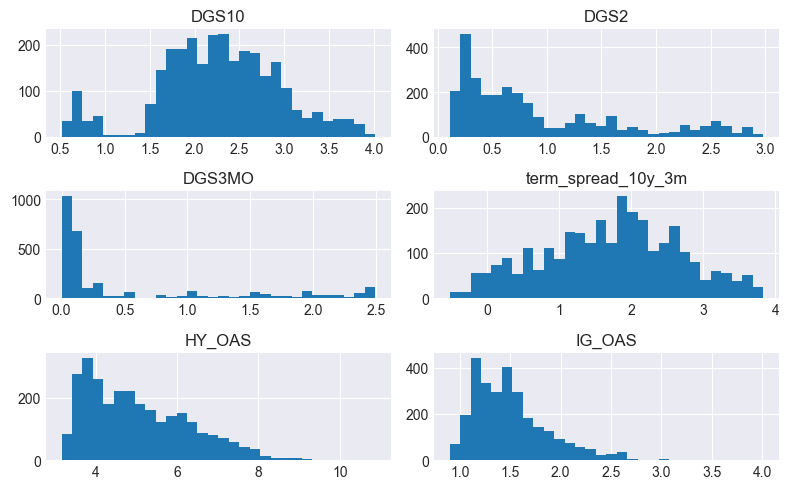

In [61]:
X_macro.hist(bins=30, figsize=(8, 5))
plt.tight_layout()
plt.show()

In [62]:
X_macro = X_macro.reindex(y.index).ffill()

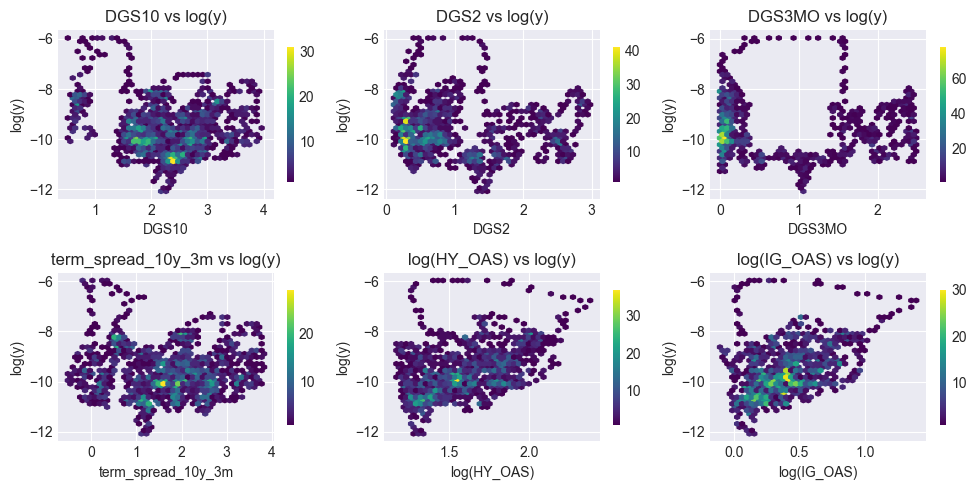

In [63]:
plot_features_vs_target(X_macro, y, log_features=["HY_OAS", "IG_OAS"], figsize=(10, 5), nrows=2, ncols=3)

#### Market / Sentiment  

Here we include **market-implied and positioning-based indicators** that reflect how “nervous” or “complacent” investors are.  
They react faster than macro variables and can help identify **risk-on / risk-off regimes**, which affect both the level and persistence of future realized volatility:  

- **VIX**: benchmark measure of 30-day implied volatility on the S&P 500; a fast-moving barometer of market fear and near-term uncertainty.  
- **VVIX**: “volatility of volatility” index, capturing how uncertain the market is about future changes in VIX itself; often spikes in unstable vol regimes.  
- **Put/Call ratio**: options volume or open-interest ratio of puts to calls (index or ETF); elevated ratios indicate demand for downside protection and risk aversion.  

These variables do not directly describe the asset’s own volatility process but provide **high-frequency information about crowd risk appetite**, making them natural **filters or conditioning variables** for IV–RV mispricing signals.

In [1029]:
def create_market_features(spx: pd.DataFrame, spx_options, start: str, end: str) -> pd.DataFrame:
    vix = yf.download(["^VIX", "^VVIX"], start=start, end=end, auto_adjust=True, progress=False)[["Close"]]
    vix.columns = [tkr.replace("^", "") for _, tkr in vix.columns]
    vix = vix.rename(columns={"VIX": "VIX", "VVIX": "VVIX"}).sort_index()

    # Business-day index + forward-fill (CBOE sometimes has gaps)
    vix = vix.asfreq("B").ffill()

    # Put / Call ratio
    put_call_ratio = {}
    for date, chain in spx_options.groupby("date"):
        volume_call = chain["c_volume"].sum()
        volume_put = chain["p_volume"].sum()

        if volume_call > 0:  # avoid div by 0
            ratio = volume_put / volume_call
        else:
            ratio = np.nan

        put_call_ratio[pd.to_datetime(date)] = ratio


    put_call_ratio = pd.Series(put_call_ratio).sort_index().rename("put_call_ratio")
    
    df = pd.concat([vix, put_call_ratio], axis=1)

    return df

In [ ]:
X_market = create_market_features(spx, spx_options, start=start, end=end)
X_market = X_market.reindex(y.index).ffill()

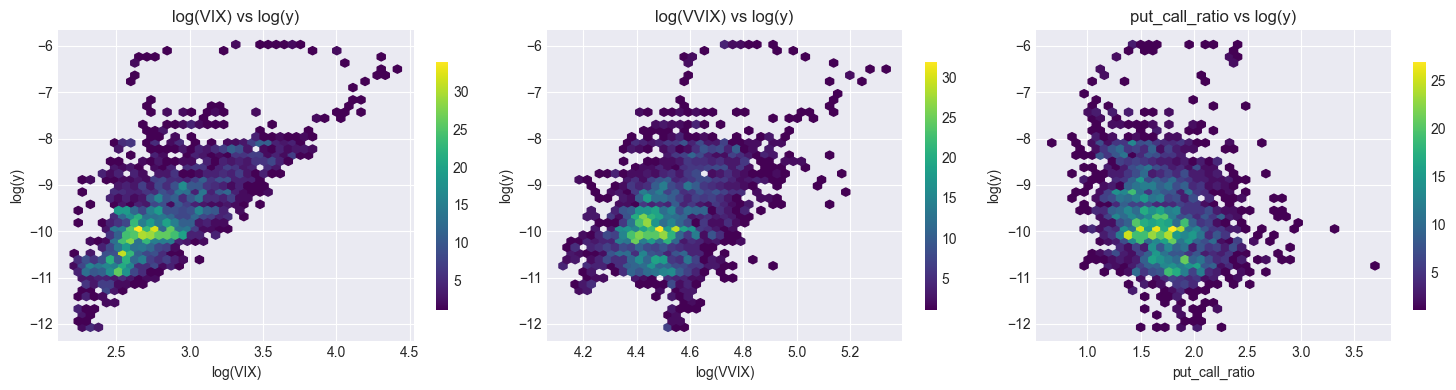

In [1032]:
plot_features_vs_target(X_market, y, log_features=["VIX", "VVIX"], figsize=(15, 4), nrows=1, ncols=3)

# **5. Feature Engineering**

We go beyond raw predictors (HAR lags, VIX, IV surface, credit spreads, etc.) by creating features that are more aligned with the forecasting task.  
The goal is to reduce noise, capture regime levels, and detect stress transitions that precede volatility spikes.  

#### Horizon-aligned smoothing  
The target is 21-day forward realized variance, so daily predictors are too noisy. We create regime-level signals:  
- 5-day / 21-day rolling means  
- EWMA smoothers  
- monthly-style RV memory  

These capture persistent volatility regimes instead of one-day noise.  

#### Regime shift / stress dynamics  
Volatility surges usually follow abrupt risk repricing. To capture this we add:  
- weekly changes in VIX, skew, credit spreads  
- VVIX/VIX ratio (vol-of-vol stress)  
- ATM IV − RV gap (risk premium proxy)  

These highlight stress transitions that often precede elevated forward RV.  

In [ ]:
def feature_engineering(
    X_core: pd.DataFrame,
    window_short: int = 5,
    window_long: int = 21,
    ewma_alpha: float = 0.2,
) -> pd.DataFrame:
    """
    Create X_eng features from economic predictors.
    Returns ONLY the X_eng features (not X_core itself).
    """
    X = X_core.copy()
    X_eng = {}

    # -------------------------------------------------
    # 1. Horizon-aligned smoothing (regime level)
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["VIX_rm5"]   = X["VIX"].rolling(window_short, min_periods=1).mean()
        X_eng["VIX_rm21"]  = X["VIX"].rolling(window_long, min_periods=1).mean()
        X_eng["VIX_ewma"]  = X["VIX"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "RV_M" in X:
        X_eng["RV_M_ewma"] = X["RV_M"].ewm(alpha=ewma_alpha, adjust=False).mean()

    if "HY_OAS" in X:
        X_eng["HY_OAS_ewma"] = X["HY_OAS"].ewm(alpha=ewma_alpha, adjust=False).mean()

    # -------------------------------------------------
    # 2. Regime shift / stress dynamics
    # -------------------------------------------------
    if "VIX" in X:
        X_eng["dVIX_5d"] = X["VIX"] - X["VIX"].shift(window_short)
        X_eng["z_score_VIX_21d"] = (X["VIX"] - X["VIX"].rolling(21).mean()) / X["VIX"].rolling(21).std()

    if "iv_skew" in X:
        X_eng["dSkew_5d"] = X["iv_skew"] - X["iv_skew"].shift(window_short)

    if "atm_iv_30d" in X and "RV_M" in X:
        X_eng["iv_minus_realized"] = X["atm_iv_30d"] - X["RV_M"]

    if "VVIX" in X and "VIX" in X:
        X_eng["vvix_over_vix"] = X["VVIX"] / X["VIX"].replace(0, np.nan)

    if "VIX" in X and "HY_OAS" in X:
        X_eng["VIX_time_HY_OAS"] = X["VIX"] * X["HY_OAS"] 
    
    if "RV_D" in X:
        X_eng["RV_D_rollvol5"] = X["RV_D"].rolling(5).std()
        X_eng["RV_D_rollvol21"] = X["RV_D"].rolling(21).std()

    # -------------------------------------------------
    # 3. Assemble into DataFrame
    # -------------------------------------------------
    X_eng = pd.DataFrame(X_eng, index=X.index)

    return X_eng

In [1098]:
X_core = pd.concat([X_har, X_iv_surface, X_macro, X_returns, X_market], axis=1)
X_eng = feature_engineering(X_core)
X = pd.concat([X_core, X_eng], axis=1)

core_features = X_core.columns.tolist()
eng_features = X_eng.columns.tolist()

X_eng.agg(summary_stats)

,VIX_rm5,VIX_rm21,VIX_ewma,RV_M_ewma,HY_OAS_ewma,dVIX_5d,z_score_VIX_21d,dSkew_5d,iv_minus_realized,vvix_over_vix,VIX_time_HY_OAS
count,2835.000000,2835.000000,2835.000000,2815.000000,2835.000000,2830.000000,2815.000000,2655.000000,2815.000000,2835.000000,2835.000000
mean,17.971053,17.960360,17.969347,0.000110,5.049248,0.005693,-0.059908,0.000013,0.149081,5.655410,97.091306
std,7.259670,6.853001,7.046994,0.000211,1.263522,3.593055,1.216615,0.014259,0.066756,1.435551,68.567904
min,9.376000,9.800000,9.614762,0.000006,3.233705,-21.100002,-2.814737,-0.127006,0.062051,2.054459,30.979201
max,74.618001,61.258572,65.811602,0.002408,9.377609,35.850002,4.129266,0.124977,0.774351,10.316940,707.040000
skew,2.536454,2.301621,2.402397,7.567750,0.713000,1.683577,0.739927,0.730190,2.616658,0.373912,3.348497
kurtosis,10.793452,8.074845,9.234084,68.422319,-0.209626,14.954005,-0.058518,10.877528,12.701030,0.257500,18.603871


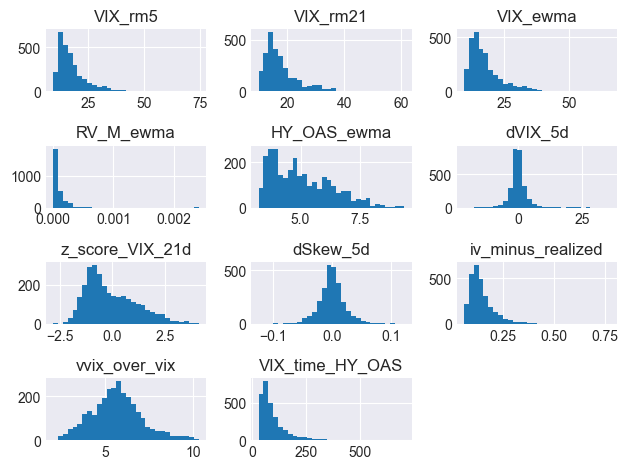

In [72]:
X_eng.hist(bins=30)
plt.tight_layout()
plt.show()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_7948/2905682424.py:18: RuntimeWarning: invalid value encountered in log
  x = np.log(x + 1e-8)  # small offset to avoid log(0)


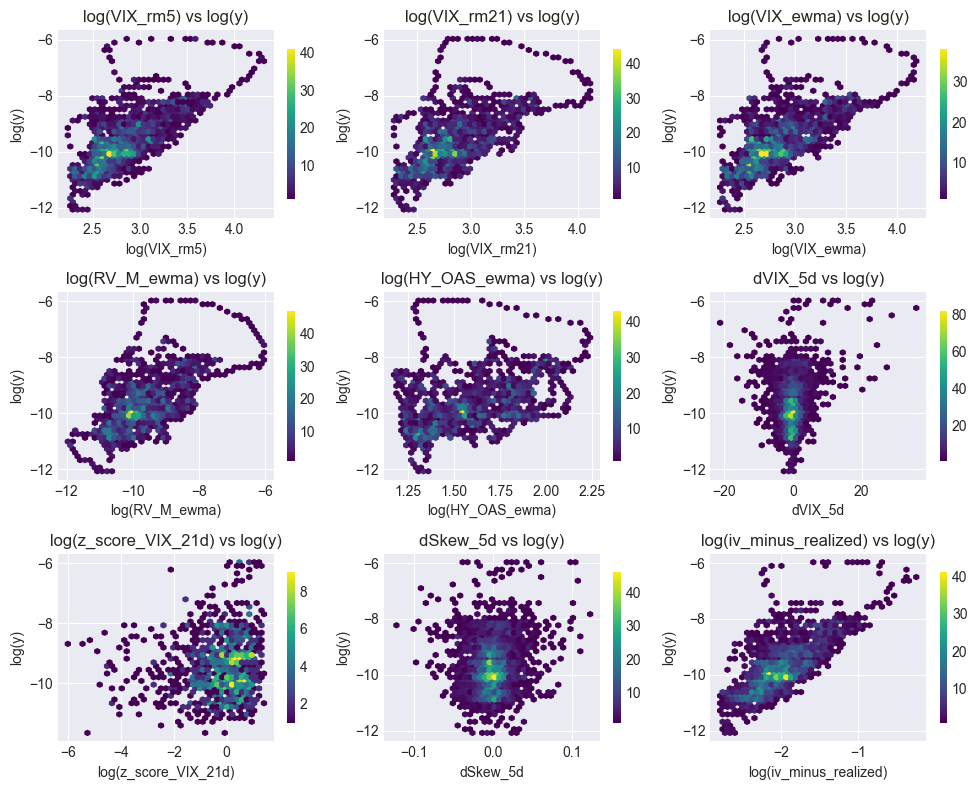

In [73]:
plot_features_vs_target(X_eng, y, log_features=list(set(eng_features) - set(["dVIX_5d", "dSkew_5d", "vvix_over_vix"])), figsize=(10, 8), nrows=3, ncols=3)

# **6. Data Preprocessing**

We inspect each predictor’s distribution (shape, skewness, tail heaviness) and only transform when necessary. The goal is to make features more symmetric and well-behaved for regression and machine learning.  

We test simple transforms first (**log**, **sqrt**). If the feature is still highly skewed, or can take negative values, we use more flexible transforms like **Yeo–Johnson** (or **Box–Cox** for strictly positive data).  

This step is not about “cheating the target,” but about stabilizing scale and reducing extreme tails so the model trains on cleaner signals. Since most predictors are already smoothed (HAR averages, rolling VIX, EWMA credit spreads), we mainly need to correct **heavy right tails** (e.g. VIX level) and **strongly asymmetric signed shocks** (e.g. ΔVIX).

In [74]:
def plot_transform_demo(series, method="log"):
    raw = series.dropna().to_numpy()

    if method == "log":
        transformed = np.log(np.clip(raw, 1e-8, None))
        tlabel = "log"
    elif method == "yeo-johnson":
        pt = PowerTransformer(method="yeo-johnson", standardize=False)
        transformed = pt.fit_transform(raw.reshape(-1,1)).ravel()
        tlabel = "Yeo-Johnson"
    else:
        raise ValueError("method must be 'log' or 'yeo-johnson'")

    # compute skew & kurtosis
    stats_raw = (skew(raw), kurtosis(raw))
    stats_trans = (skew(transformed), kurtosis(transformed))

    # plotting
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # raw
    axes[0].hist(raw, bins=40, alpha=0.7, color="steelblue")
    axes[0].set_title(f"Distribution of {series.name} (raw)")
    axes[0].text(0.95, 0.95, f"Skew={stats_raw[0]:.2f}\nKurt={stats_raw[1]:.2f}",
                 transform=axes[0].transAxes, ha="right", va="top",
                 bbox=dict(facecolor="white", alpha=0.7))

    # transformed
    axes[1].hist(transformed, bins=40, alpha=0.7, color="darkorange")
    axes[1].set_title(f"Distribution of {series.name} ({tlabel})")
    axes[1].text(0.95, 0.95, f"Skew={stats_trans[0]:.2f}\nKurt={stats_trans[1]:.2f}",
                 transform=axes[1].transAxes, ha="right", va="top",
                 bbox=dict(facecolor="white", alpha=0.7))

    plt.tight_layout()
    plt.show()

### Log Transformation on rigth skewed data

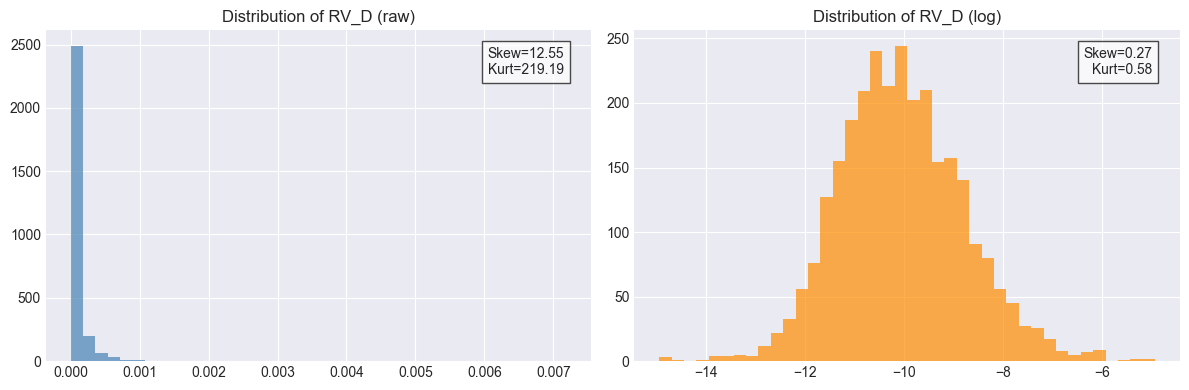

In [75]:
plot_transform_demo(X["RV_D"], method="log")

### Yeo-Johnson to <= 0 data

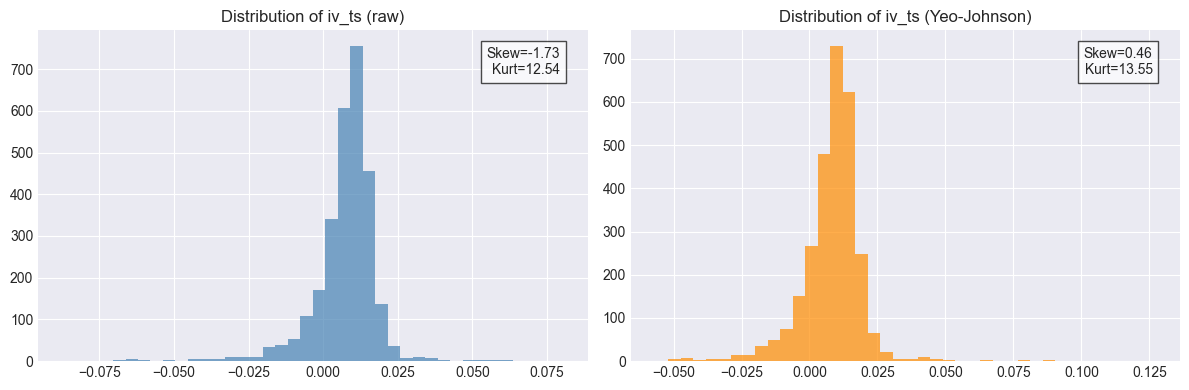

In [76]:
plot_transform_demo(X["iv_ts"], method="yeo-johnson")

In [77]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Apply log(x) to strictly-positive features.
    We'll also expose get_feature_names_out so ColumnTransformer
    can build readable names.
    """
    def __init__(self, eps=1e-8):
        self.eps = eps
        self.feature_names_in_ = None  # store input column names

    def fit(self, X, y=None):
        # X will be a 2D array when called inside ColumnTransformer.
        # But ColumnTransformer will also set feature_names_in_ for us
        # if it passes DataFrame cols. We'll capture that ourselves.
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X = np.log(np.clip(X, self.eps, None))
        return X

    def set_output(self, *, transform=None):
        # for sklearn compatibility; can just return self
        return self

    def get_feature_names_out(self, input_features=None):
        """
        input_features: list/array of original column names that went
        through this transformer.
        We return names like 'log__VIX', 'log__RV_M', etc.
        """
        if input_features is None:
            # fallback to generic names if sklearn doesn't pass them
            return np.array(["log_feature_" + str(i) for i in range(self.n_features_in_)])
        return np.array([f"log__{feat}" for feat in input_features])


class DataProcessor(BaseEstimator, TransformerMixin):
    def __init__(self,
                 log_features=None,
                 yeo_johnson_features=None,
                 scale=True):
        """
        log_features: list of column names to log-transform
        yeo_johnson_features: list of column names to Yeo-Johnson transform
        scale: bool, whether to StandardScale the final feature matrix

        Any column not in either list will be passed through unchanged.
        """
        self.log_features = log_features or []
        self.yeo_johnson_features = yeo_johnson_features or []
        self.scale = scale

        # will be built in fit()
        self.preprocessor_ = None
        self.pipeline_ = None
        self.feature_names_out_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X).copy()
        all_cols = list(X_df.columns)

        # columns that are neither log nor YJ
        passthrough_cols = [
            c for c in all_cols
            if c not in self.log_features and c not in self.yeo_johnson_features
        ]

        # build the column-wise transformer
        self.preprocessor_ = ColumnTransformer(
            transformers=[
                # Yeo-Johnson on signed / skewed features
                ("yeo_johnson",
                 PowerTransformer(method="yeo-johnson", standardize=False),
                 self.yeo_johnson_features),

                # log on strictly-positive heavy-tail features
                ("log",
                 LogTransformer(),
                 self.log_features),

                # passthrough the rest untouched
                ("passthrough",
                 "passthrough",
                 passthrough_cols),
            ],
            remainder="drop",  # we've already handled all cols explicitly
            verbose_feature_names_out=False
        )

        # now build the final pipeline (preprocess -> optional scaling)
        steps = [("preprocess", self.preprocessor_)]
        if self.scale:
            steps.append(("scaler", StandardScaler()))

        self.pipeline_ = Pipeline(steps)

        # fit the whole pipeline
        self.pipeline_.fit(X_df, y)

        # store feature names after preprocess step (before scaler)
        # note: get_feature_names_out is available from sklearn >=1.0-ish
        try:
            self.feature_names_out_ = self.preprocessor_.get_feature_names_out()
        except AttributeError:
            self.feature_names_out_ = None

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X).copy()
        X_arr = self.pipeline_.transform(X_df)
        return X_arr

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

    def get_feature_names_out(self):
        """
        Returns names of features *after* preprocess (before scaling).
        If scaling is applied, scaler doesn't change dimensionality,
        so names still line up.
        """
        return self.feature_names_out_

In [1101]:
log_features = [
    "VIX", "VVIX",
    "RV_D", "RV_W", "RV_M",
    "atm_iv_30d",
    "VIX_rm5", "VIX_rm21", "VIX_ewma",
    "RV_M_ewma",
    "HY_OAS_ewma", "HY_OAS", "IG_OAS",
    "kurt", "iv_minus_realized", "iv_skew" # volume
]

yj_features = [
    "iv_ts", "r2", "abs_r"
]

processor = DataProcessor(
    log_features=log_features,
    yeo_johnson_features=yj_features,
    scale=True
)

X_proc = processor.fit_transform(X)
X_proc = pd.DataFrame(X_proc, index=X.index, columns=processor.get_feature_names_out())
X_proc

,iv_ts,r2,abs_r,log__VIX,log__VVIX,log__RV_D,log__RV_W,log__RV_M,log__atm_iv_30d,log__VIX_rm5,...,DGS2,DGS3MO,term_spread_10y_3m,skew,put_call_ratio,dVIX_5d,z_score_VIX_21d,dSkew_5d,vvix_over_vix,VIX_time_HY_OAS
2010-01-04,1.669896,NaN,NaN,0.511823,-1.482700,-1.201719,NaN,NaN,0.535277,0.514304,...,0.242626,-0.614202,2.149840,NaN,0.640479,NaN,NaN,NaN,-1.391854,0.437050
2010-01-05,1.870422,-0.489525,-0.487866,0.407436,-1.745959,-0.533214,NaN,NaN,0.428315,0.461670,...,0.135529,-0.627083,2.076820,NaN,0.977985,NaN,NaN,NaN,-1.406840,0.361949
2010-01-06,1.660736,-0.559457,-1.306110,0.378038,-1.998555,-0.849765,NaN,NaN,0.406672,0.434101,...,0.135529,-0.639965,2.170703,NaN,0.154022,NaN,NaN,NaN,-1.480262,0.308156
2010-01-07,1.627956,-0.443224,-0.253413,0.362447,-2.046263,-0.692336,NaN,NaN,0.356340,0.416319,...,0.162303,-0.652846,2.181135,NaN,-0.407822,NaN,NaN,NaN,-1.485632,0.260233
2010-01-08,1.880213,-0.499890,-0.553534,0.213413,-2.185674,-0.741751,-1.172517,NaN,0.279996,0.376300,...,0.068593,-0.652846,2.160272,NaN,1.273309,NaN,NaN,NaN,-1.415059,0.175788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.342907,-0.468904,-0.373707,0.725487,1.428183,-1.068225,0.877790,0.114470,0.688542,0.952865,...,-1.042538,-0.601320,-0.896161,0.984234,1.346527,-0.112930,-0.306331,0.003872,-0.210375,-0.144332
2020-12-28,0.868684,-0.020706,0.688085,0.748918,1.380019,0.586347,0.895246,0.175637,0.426633,0.956266,...,-1.042538,-0.575557,-0.917024,1.029893,1.294083,0.034603,-0.219418,0.580270,-0.267207,-0.184934
2020-12-29,0.603040,-0.524506,-0.744501,0.932602,1.484291,-0.523537,-0.397823,0.159649,0.665213,0.901392,...,-1.055926,-0.588439,-0.906592,0.991275,1.714673,-0.580581,0.557135,-0.326601,-0.430374,-0.120096
2020-12-30,0.414635,-0.548222,-1.028629,0.892315,1.245963,-0.788120,-0.428995,0.092024,0.604862,0.862272,...,-1.055926,-0.614202,-0.896161,1.127543,0.401898,-0.407996,0.313343,-0.915390,-0.512020,-0.130863


# **7. Feature Selection**

Filter Methods: 
    Correlation Heatmap
    Mutual Information

Wrapper methods for HAR family:
start with HAR lags + IV lags + overnight + leevarge effect + ....
and see for the top 10 features and create hAR-models accordingly (consider only the HAR-X features)

Embedded methods:
    For ML models with all features -> Embedded

•	Discuss which predictors are most important for SPX RV.


For linear models, correlation filter, Wrapper method (Lasso) after that -> come up with economic ration al models HAR-VR, HAR-RV-IV, HAR-RV-X ... leevarge the results of Wrapper methods to come up with linear regression mdoels (X_all, X_top_5, X_top_10)
Consider Lasso on top 15 features

For ML models, correlation filter, Wrapper method (RF) + embedded method -> X_top_10, X_top_15


Linear feature set vs Non-Linear(with potential interaction effects) feature set



In [1102]:
y = create_forward_target(daily_rv, horizon=21)

data = pd.concat([X_proc, y], axis=1)
data = data.dropna()

X_clean = data[X_proc.columns]
y_clean = data[y.name]

## 6.1 Clean & sanity filter

In [950]:
from sklearn.feature_selection import VarianceThreshold

selector_var = VarianceThreshold(threshold=0.10) # Remove feature with < 1% variance

#X_clean = selector_var.fit_transform(X_clean)

## 6.2 Correlation / redundancy check

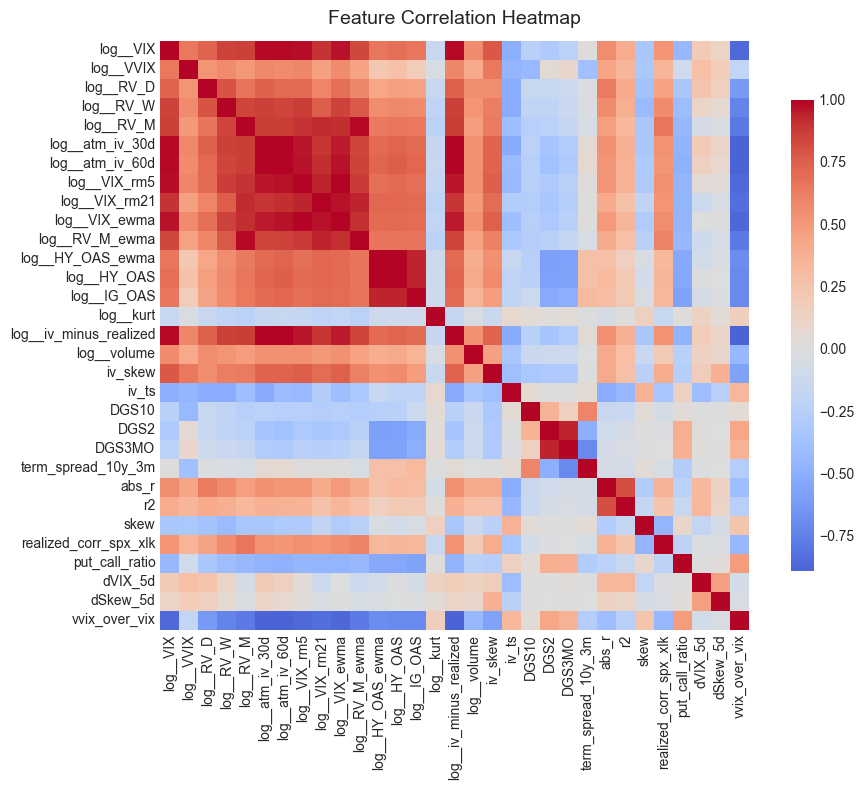

In [928]:
plt.figure(figsize=(10, 8))  # adjust size
corr = X_proc.corr()

sns.heatmap(
    corr,
    cmap="coolwarm",        
    center=0,               
    annot=False,            
    fmt=".2f",              
    square=True,          
    cbar_kws={"shrink": .8}
)

plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

IV and VIX fetaure are highly correlated. In constract other fetaure like returns and macro show low correlation among themselves.

## 6.3 Linear model relevance: Lasso Cross-Validation

Here we apply Embedded methods using Lasso and Eslatic Net (penalzies more too correlated features) to emphasize teh msot imporatnt feature that align with teh target.

# In-sample feature importance
Linear Models -> use weigths of given by Lasso

NON-Linear Models -> use MDI by creating own algo

# # Out-sample feature importance
Use both permutation imporatnce (MDI over QLIKE Loss or RSME)

# Out of sample wihtiout substituion effetcs
Using SIngle feature Imporatnce (fit eahc feature indivudally, evaulaute on OOS)



- Comapre the importanc eover volatiltiy regimes using Gaussian Mixture Models

<Axes: >

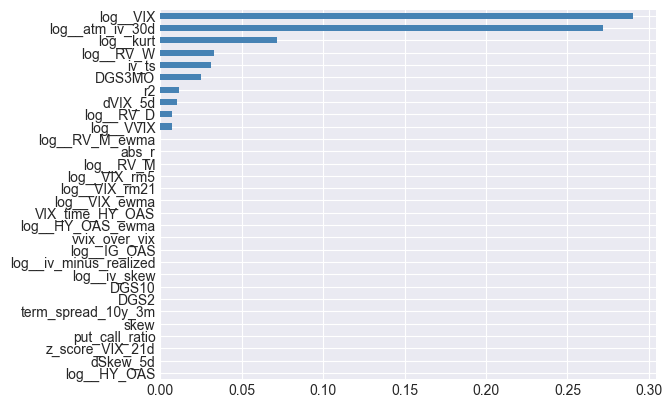

In [1103]:
tscv = TimeSeriesSplit(n_splits=5)

lasso_fs = LassoCV(
        alphas=np.logspace(-4, 0, 30),
        cv=tscv,
        max_iter=100000,
        n_jobs=-1
)

lasso_fs.fit(X_clean, y_clean)

lasso_imp = pd.Series(np.abs(lasso_fs.coef_), index=X_clean.columns)
lasso_imp = lasso_imp.sort_values(ascending=True)
lasso_imp.plot(kind="barh", color="steelblue")

In [ ]:
top_3_features_lin = lasso_imp.tail(3).index.tolist()
top_5_features_lin = lasso_imp.tail(5).index.tolist()
top_10_features_lin = lasso_imp.tail(10).index.tolist()

## 6.3 Tree model  relevance

Here we apply Embedded methods using Random forecast Feature imporatnce score to rank fetaures showing the ebst predciitve accuarcy with the target.

Here the idea is to dsicoevr in the reserach ste whihc features are used to explain the target (and not predict since it is in-sample). So they cna be used to remove compleytely useless features whihc is never selected by any tree to decerase impurity (can be quite confident it will have no predicitve accutacy OOS)

### Feature importance: Mean Decrease Impurity

<Axes: >

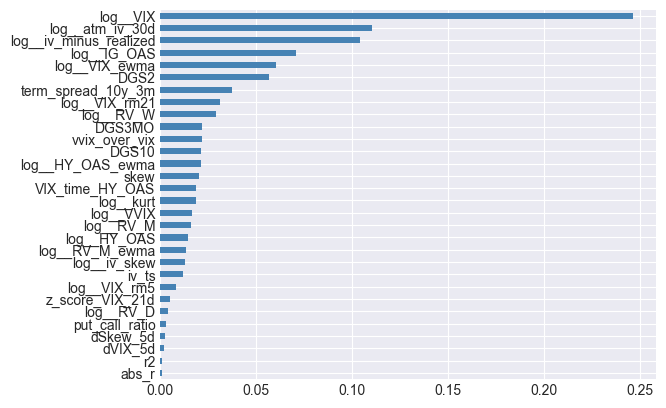

In [1105]:
rf_probe = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=0,
    n_jobs=-1,
    oob_score=True # Out-of-Bag validation performance
)

rf_probe.fit(X_clean, y_clean)

rf_imp = pd.Series(rf_probe.feature_importances_, index=X_proc.columns)
rf_imp = rf_imp.sort_values(ascending=True)

rf_imp.plot(kind="barh", color="steelblue")

### Permutation Imporatnce: Mean Decrease Accuracy

While MDI was used in-sample measuring the decerase impurity from the split of a given feature, permutaion imporatcne focuses is based on OOS data and consists in trainign a model on train data, and on a valdiaiton data randomly permutign rows of each column to see the average dcereas ein predicitve power. Here we use MDI just to identify and potentailly remove features with 0 imporatnce at all as they show 0 relationship wiht teh target, as here the MDA is used taking into accoutn the forecatsign power of eahc column.

Despite low importance features, since tree base models are robsut to mild unhelpful features we decide to not **pre-prunne** to keep all of them and will apply robsut cross validation latter to **post-pruning**. Indeed, dSkew, r2 and abs2, put-call-ratio may amtter less on average, but under tail regimes they amtetr a lot as they capture large vol spikes.

# **4. Model Classes**

FOrecasting is about fitting a model that minimized a cost function -> QLIKE or RMSE


## Linear Models:

### Econometrics models: HAR-RV, HAR-RV-IV, HAR-VIX
According to the literature and the observation

### Linear Regression models: OLS, Lasso, Ridge on the feature selected ones
Accoridng to statistical information

## Non-Linear models
In the EDA steps we observed some non-linearity (remember vvix_over_vix and otehr features had a nice polymnial relatinships)

### Ensemble tree based models
Capture non-linear and interactions effect between the features usign teh enriched dataset

### Neural Networks (LSTM)
Because of the long memory charasteristic we consider LSTM model that capture this
(something that RF might noty cpature jsut with rolling mean features)

# **4. Forecasting 21-D Realized Volatility**

FOrecasting is about fitting a model that minimized a cost function -> QLIKE or RMSE

---

### Why 21-Day Horizon?

- **Options market alignment:**  
  The 21-day horizon corresponds to ~1 month of trading days, matching the 30-day maturity of the most liquid index options.  
  This is also the tenor underlying the **VIX index**, which represents the market’s expectation of 30-day implied volatility.

- **Smoother target:**  
  Forward 21-day RV is much less noisy than daily RV.  
  Aggregating returns over a month produces a smoother series, closer to a rolling mean, which helps extract meaningful patterns.  
  This improves predictive power (higher $R^2$) and makes models more robust.

In [15]:
from abc import ABC, abstractmethod

class BaseRVForecaster(ABC):
    def __init__(self, H=21, name=None):
        self.H = H
        self.name = name or self.__class__.__name__

    @abstractmethod
    def fit(self, returns: pd.Series, rv: pd.Series, **kwargs):
        """Estimate parameters using a TRAIN window (no look-ahead)."""

    def warm_state(self, returns: pd.Series, rv: pd.Series):
        """Update internal state with observed data (no parameter re-fit)."""
        return self

    @abstractmethod
    def forecast(self, as_of_index: pd.DatetimeIndex) -> pd.Series:
        """Return ex-ante H-horizon RV forecast indexed by as_of_index."""


## **4.1 Log HAR-RV**

HAR-G -> residuals are heterosckedastic

## **4.1 GARCH family of models (GARCH(1, 1), EGARCH, GJR-GARCH)**

FIGARCH / HYGARCH — for long-memory volatility (useful for multi-day forecasts).

## **4.1 Machine Learning models (Bayesian RIDGE, Lasso, Random Forest, XGboost, LSTM)**

3. Long horizon (1-month ≈ 21D forward RV, or 3M)
	•	Predictability: much higher, smoother target, strong persistence and mean reversion.
	•	Economic relevance: directly matches option tenors (VIX = 30D, 3M IV).
	•	ML: more useful here because:
	•	Nonlinearities matter (IV term structure, skew effects, macro regimes).
	•	More predictors can be included (macro, credit spreads, realized correlations).
	•	HAR/GARCH become restrictive, while ML can flexibly combine many signals.
	•	Verdict: Best horizon for ML.

## **4.1 Ensemble Model**

Take the best model of each family and create an esnbmel fo predicitons. Either simple average prediciton, or weighted preidction 1/RMSE, bayesian modelling of the weights, kalman filters for dynamic parameters, markov-swithcing models in low vs high volaility regimes.
Once a model is chsoen for a given family keep it for the all testing, jsut update the weights dinamically and refit the mdoel every month or week. 
For HAR and GARCH family of models, can use AIC and QLIKE as well as LR tets for incremental parameters.

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from arch import arch_model
from sklearn.ensemble import GradientBoostingRegressor

class RVForecaster:
    def __init__(self, returns, rv):
        """
        Parameters
        ----------
        returns : pd.Series
            Daily log returns of the underlying.
        rv : pd.Series
            Realized volatility series (e.g. 21D rolling, annualized).
        """
        self.returns = returns.dropna()
        self.rv = rv.dropna()
    
    # === EWMA ===
    def ewma(self, lam=0.94):
        """RiskMetrics EWMA volatility forecast."""
        sigma2 = 0
        forecasts = []
        for r in self.returns:
            sigma2 = lam * sigma2 + (1 - lam) * r**2
            forecasts.append(np.sqrt(sigma2 * 252))
        return pd.Series(forecasts, index=self.returns.index, name="EWMA")
    
    # === HAR-RV ===
    def har(self, lags=(1,5,22)):
        """HAR-RV model using daily/weekly/monthly realized vol."""
        df = pd.DataFrame({"RV": self.rv})
        for lag in lags:
            df[f"lag{lag}"] = self.rv.shift(lag).rolling(lag).mean()
        df = df.dropna()
        X = sm.add_constant(df[[f"lag{l}" for l in lags]])
        model = OLS(df["RV"], X).fit()
        forecast = model.predict(X)
        return forecast.rename("HAR-RV")
    
    # === GARCH(1,1) ===
    def garch(self):
        """GARCH(1,1) forecast."""
        model = arch_model(self.returns*100, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1).variance.iloc[:,0]**0.5 / 100
        forecast = forecast.rename("GARCH(1,1)")
        return forecast
    
    # === ML (GBM by default) ===
    def ml(self, features, model=None):
        """Forecast RV using ML (GradientBoosting by default)."""
        if model is None:
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        X = features.shift(1).dropna()
        y = self.rv.loc[X.index]
        model.fit(X, y)
        forecast = pd.Series(model.predict(X), index=X.index, name="ML-RV")
        return forecast

ModuleNotFoundError: No module named 'arch'